#LIBRARIES

In [ ]:
from google.colab import drive
drive.mount('/content/drive') #connecting to google drive with data

Mounted at /content/drive


In [ ]:
!pip install torchmetrics
import os
import torch
import numpy as np
import nibabel as nib  # fro reading 3D medical images
import torchvision
import torchvision.transforms.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import maskrcnn_resnet50_fpn
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from skimage.transform import resize
import matplotlib.patches as patches
import pandas as pd
from torchvision.models.detection import MaskRCNN
from torchvision.models import resnet50
from torchvision import transforms
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.anchor_utils import AnchorGenerator
from sklearn.metrics import precision_score, recall_score, f1_score
from torchvision.transforms import functional as F
from tqdm import tqdm
import random
from torchvision.ops import box_iou
from torch.optim.lr_scheduler import ReduceLROnPlateau, LambdaLR
import warnings
from matplotlib.colors import ListedColormap
import torch.nn.functional as F_nn
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR

#PREPROCESSING

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
INPUT_SIZE = (256, 256)  # resizing all slices to this size

In [ ]:
def log_min_max(image, message):
    print(f"{message}: min={image.min()}, max={image.max()}")

def apply_window(image, level, width):
    min_val = level - (width / 2) # 450
    max_val = level + (width / 2) # 1300
    log_min_max(image, "Before windowing") # keeping track of changes
    image = np.clip(image, min_val, max_val)
    log_min_max(image, "After windowing")
    return image

def normalize_intensity(image, min_intensity, max_intensity):
    log_min_max(image, "Before normalization")
    image = (image - min_intensity) / (max_intensity - min_intensity)  # normalizing to [0, 1]
    log_min_max(image, "After normalization (before clipping)")
    image = np.clip(image, 0, 1)
    log_min_max(image, "After clipping")
    return image

In [ ]:
def load_label_mapping(csv_file): #relabaleling based on csv
    df = pd.read_csv(csv_file)
    label_mapping = {}
    for _, row in df.iterrows():
        if row['public_id'] not in label_mapping:
            label_mapping[row['public_id']] = {}
        label_mapping[row['public_id']][row['label_id']] = row['label_code']
    return label_mapping

In [ ]:
def resize_volume(volume, target_size, mode='constant', order=3): #resizing slices with different interpolations for images and labels
    resized = np.zeros((target_size[0], target_size[1], volume.shape[2]))
    for z in range(volume.shape[2]):
        resized[:, :, z] = resize(volume[:, :, z], target_size,mode=mode,order=order,anti_aliasing=(order > 0))
    return resized

In [ ]:
def preprocess_and_save_tensor(ct_scan_folder, label_folder, output_folder, input_size, label_mapping, drop_prob=0.7): #complplete preprocessing pipeline

    os.makedirs(output_folder, exist_ok=True)

    #matching CT and labels
    ct_files = sorted([f for f in os.listdir(ct_scan_folder) if f.endswith(('.nii', '.nii.gz'))]) #the images where already decompressed but just in case put .gz
    label_files = sorted([f for f in os.listdir(label_folder) if f.endswith(('.nii', '.nii.gz'))])

    for ct_file, label_file in zip(ct_files, label_files):
        try:
            ct_scan = nib.load(os.path.join(ct_scan_folder, ct_file)).get_fdata() #loading data
            label_vol = nib.load(os.path.join(label_folder, label_file)).get_fdata()

            public_id = ct_file.split('-')[0]
            if public_id not in label_mapping:
                continue

            ct_scan = resize_volume(ct_scan, input_size, order=3) # resizing with ct interpolation
            label_vol = resize_volume(label_vol, input_size, order=0) # 0 is label interpolation

            ct_scan = normalize_intensity(apply_window(ct_scan, level=450, width=1300), -1000, 1000) #normlizing intrensity

            for z in range(1, label_vol.shape[2]-1):
                current_slice = label_vol[:,:,z].copy()

                # Remap labels
                for orig_id, new_id in label_mapping[public_id].items(): #remapping label
                    current_slice[current_slice == orig_id] = new_id
                current_slice[current_slice == -1] = 5  # changing -1 undeidentified fracture to 5

                if np.all(current_slice == 0) and random.random() < drop_prob: #skipping empty slices (with probability)
                    continue

                #processing fractures
                masks, boxes, labels = [], [], []

                for lbl in np.unique(current_slice):
                    if lbl == 0:
                        continue

                    binary_mask = (current_slice == lbl).astype(np.uint8)  # craeting binary mask fro one fracture

                    labeled_mask = label_components(binary_mask) #finding connected components

                    # processing each component
                    for i in range(1, labeled_mask.max()+1):
                        mask = (labeled_mask == i).astype(np.uint8)

                        if mask.sum() < 5:  #skipping small fractures fro efficiency
                            continue

                        # special handling of label 5. NOTE: not a problem anymore. data was fixed
                        if lbl == 5:
                            if mask.sum() > 500:  # skipping large blobs
                                continue

                        # calculating bounding box
                        y, x = np.where(mask)
                        ymin, ymax = np.min(y), np.max(y)
                        xmin, xmax = np.min(x), np.max(x)

                        # adding margin (clamped to image bounds)
                        margin = 2
                        ymin = max(0, ymin - margin)
                        xmin = max(0, xmin - margin)
                        ymax = min(input_size[0]-1, ymax + margin)
                        xmax = min(input_size[1]-1, xmax + margin)

                        if xmin >= xmax or ymin >= ymax:
                            continue

                        # craeting full-size mask for each fracture
                        full_mask = np.zeros(input_size, dtype=np.uint8)
                        full_mask[ymin:ymax+1, xmin:xmax+1] = mask[ymin:ymax+1, xmin:xmax+1]

                        masks.append(full_mask)
                        boxes.append([xmin, ymin, xmax, ymax])
                        labels.append(lbl)

                # Handle empty slices - FIXED DUMMY BOX
                if not masks:
                    dummy_size = 8 # box of 8x8
                    x1, y1 = 0, 0
                    x2, y2 = x1 + dummy_size, y1 + dummy_size  # proper calculation

                    dummy_mask = np.zeros(input_size, dtype=np.uint8)
                    dummy_mask[y1:y2, x1:x2] = 1

                    masks = [dummy_mask]
                    boxes = [[x1, y1, x2, y2]]
                    labels = [0]

                # stacking triplet slices and save
                slice_img = np.stack([
                    ct_scan[:,:,z-1],
                    ct_scan[:,:,z],
                    ct_scan[:,:,z+1]
                ], axis=0)

                torch.save(
                        {'image': torch.FloatTensor(slice_img),
                        'masks': torch.ByteTensor(np.stack(masks)),
                        'boxes': torch.FloatTensor(boxes),
                        'labels': torch.LongTensor(labels)},

                    os.path.join(output_folder, f"{public_id}_slice{z}.pt"))

        except Exception as e:
            print(f"Error processing {ct_file}: {str(e)}")
            continue

In [ ]:
# TRAIN DATA
CT_SCANS_FOLDER = '/content/drive/MyDrive/2503_30_train_ct'
LABELS_FOLDER = '/content/drive/MyDrive/2503_30_train_label'
OUTPUT_FOLDER="/content/drive/MyDrive/11_04_50_processed_train"

csv_file = '/content/drive/MyDrive/ribfrac-train-info-1.csv'   # path to the CSV file
label_mapping = load_label_mapping(csv_file)
preprocess_and_save_tensor(CT_SCANS_FOLDER, LABELS_FOLDER, OUTPUT_FOLDER, INPUT_SIZE, label_mapping,drop_prob=0.7)

Before windowing: min=-3024.0, max=1624.8623772616143
After windowing: min=-200.0, max=1100.0
Before normalization: min=-200.0, max=1100.0
After normalization (before clipping): min=0.4, max=1.05
After clipping: min=0.4, max=1.0
Before windowing: min=-1024.0, max=3060.0
After windowing: min=-200.0, max=1100.0
Before normalization: min=-200.0, max=1100.0
After normalization (before clipping): min=0.4, max=1.05
After clipping: min=0.4, max=1.0
Before windowing: min=-3024.0, max=1514.1711929876165
After windowing: min=-200.0, max=1100.0
Before normalization: min=-200.0, max=1100.0
After normalization (before clipping): min=0.4, max=1.05
After clipping: min=0.4, max=1.0
Before windowing: min=-3024.0, max=2274.7630769155726
After windowing: min=-200.0, max=1100.0
Before normalization: min=-200.0, max=1100.0
After normalization (before clipping): min=0.4, max=1.05
After clipping: min=0.4, max=1.0
Before windowing: min=-3024.0, max=3071.0
After windowing: min=-200.0, max=1100.0
Before normali

In [ ]:
# VALIDATION DATA
CT_SCANS_FOLDER = '/content/drive/MyDrive/2503_10_val_ct'
LABELS_FOLDER = '/content/drive/MyDrive/2503_10_val_label'
OUTPUT_FOLDER="/content/drive/MyDrive/1104_15_processed_val"

csv_file = '/content/drive/MyDrive/ribfrac-train-info-1.csv'   # path to the CSV file
label_mapping = load_label_mapping(csv_file)
preprocess_and_save_tensor(CT_SCANS_FOLDER, LABELS_FOLDER, OUTPUT_FOLDER, INPUT_SIZE, label_mapping,drop_prob=0.7)

Before windowing: min=-3024.0, max=1556.361791173428
After windowing: min=-200.0, max=1100.0
Before normalization: min=-200.0, max=1100.0
After normalization (before clipping): min=0.4, max=1.05
After clipping: min=0.4, max=1.0
Before windowing: min=-3024.0, max=1572.7204890392106
After windowing: min=-200.0, max=1100.0
Before normalization: min=-200.0, max=1100.0
After normalization (before clipping): min=0.4, max=1.05
After clipping: min=0.4, max=1.0
Before windowing: min=-3024.0, max=2023.9362369674122
After windowing: min=-200.0, max=1100.0
Before normalization: min=-200.0, max=1100.0
After normalization (before clipping): min=0.4, max=1.05
After clipping: min=0.4, max=1.0
Before windowing: min=-1024.0, max=3071.0
After windowing: min=-200.0, max=1100.0
Before normalization: min=-200.0, max=1100.0
After normalization (before clipping): min=0.4, max=1.05
After clipping: min=0.4, max=1.0
Before windowing: min=-1024.0, max=2980.137892185026
After windowing: min=-200.0, max=1100.0
Befo

In [ ]:
# TEST DATA
CT_SCANS_FOLDER = '/content/drive/MyDrive/test_ct'
LABELS_FOLDER = '/content/drive/MyDrive/test_label'
OUTPUT_FOLDER="/content/drive/MyDrive/1104_15_processed_test"

csv_file = '/content/drive/MyDrive/ribfrac-train-info-1.csv'   # path to the CSV file
label_mapping = load_label_mapping(csv_file)
preprocess_and_save_tensor(CT_SCANS_FOLDER, LABELS_FOLDER, OUTPUT_FOLDER, INPUT_SIZE, label_mapping,drop_prob=0.5)

Before windowing: min=-3024.0, max=1624.462207379941
After windowing: min=-200.0, max=1100.0
Before normalization: min=-200.0, max=1100.0
After normalization (before clipping): min=0.4, max=1.05
After clipping: min=0.4, max=1.0
Before windowing: min=-1024.0, max=1902.9737775526262
After windowing: min=-200.0, max=1100.0
Before normalization: min=-200.0, max=1100.0
After normalization (before clipping): min=0.4, max=1.05
After clipping: min=0.4, max=1.0
Before windowing: min=-1024.0, max=3071.0
After windowing: min=-200.0, max=1100.0
Before normalization: min=-200.0, max=1100.0
After normalization (before clipping): min=0.4, max=1.05
After clipping: min=0.4, max=1.0
Before windowing: min=-3024.0, max=3071.0
After windowing: min=-200.0, max=1100.0
Before normalization: min=-200.0, max=1100.0
After normalization (before clipping): min=0.4, max=1.05
After clipping: min=0.4, max=1.0
Before windowing: min=-3024.0, max=3071.0
After windowing: min=-200.0, max=1100.0
Before normalization: min=-

In [ ]:
# added more data to tarin dataset = 50 more
CT_SCANS_FOLDER = '/content/drive/MyDrive/added_train_ct'
LABELS_FOLDER = '/content/drive/MyDrive/added_train_label'
OUTPUT_FOLDER="/content/drive/MyDrive/11_04_50_processed_train"

csv_file = '/content/drive/MyDrive/ribfrac-train-info-1.csv'  # path to the CSV file
label_mapping = load_label_mapping(csv_file)
preprocess_and_save_tensor(CT_SCANS_FOLDER, LABELS_FOLDER, OUTPUT_FOLDER, INPUT_SIZE, label_mapping,drop_prob=0.7)

Before windowing: min=-3024.0, max=1906.0702807777186
After windowing: min=-200.0, max=1100.0
Before normalization: min=-200.0, max=1100.0
After normalization (before clipping): min=0.4, max=1.05
After clipping: min=0.4, max=1.0
Before windowing: min=-1024.0, max=2900.8857796579223
After windowing: min=-200.0, max=1100.0
Before normalization: min=-200.0, max=1100.0
After normalization (before clipping): min=0.4, max=1.05
After clipping: min=0.4, max=1.0
Before windowing: min=-3024.0, max=3071.0
After windowing: min=-200.0, max=1100.0
Before normalization: min=-200.0, max=1100.0
After normalization (before clipping): min=0.4, max=1.05
After clipping: min=0.4, max=1.0
Before windowing: min=-3024.0, max=1809.6504415833476
After windowing: min=-200.0, max=1100.0
Before normalization: min=-200.0, max=1100.0
After normalization (before clipping): min=0.4, max=1.05
After clipping: min=0.4, max=1.0
Before windowing: min=-1024.0, max=3071.0
After windowing: min=-200.0, max=1100.0
Before normali

In [ ]:
# added more data to validation dataset = 10 more
CT_SCANS_FOLDER = '/content/drive/MyDrive/added_val_ct'
LABELS_FOLDER = '/content/drive/MyDrive/added_val_label'
OUTPUT_FOLDER="/content/drive/MyDrive/1104_15_processed_val"

csv_file = '/content/drive/MyDrive/ribfrac-train-info-1.csv'   # path to the CSV file
label_mapping = load_label_mapping(csv_file)
preprocess_and_save_tensor(CT_SCANS_FOLDER, LABELS_FOLDER, OUTPUT_FOLDER, INPUT_SIZE, label_mapping,drop_prob=0.7)

Before windowing: min=-3024.0, max=1564.4000386680798
After windowing: min=-200.0, max=1100.0
Before normalization: min=-200.0, max=1100.0
After normalization (before clipping): min=0.4, max=1.05
After clipping: min=0.4, max=1.0
Before windowing: min=-3024.0, max=1756.4299950288753
After windowing: min=-200.0, max=1100.0
Before normalization: min=-200.0, max=1100.0
After normalization (before clipping): min=0.4, max=1.05
After clipping: min=0.4, max=1.0
Before windowing: min=-3024.0, max=1928.9916841773545
After windowing: min=-200.0, max=1100.0
Before normalization: min=-200.0, max=1100.0
After normalization (before clipping): min=0.4, max=1.05
After clipping: min=0.4, max=1.0
Before windowing: min=-1024.0, max=1890.880754551693
After windowing: min=-200.0, max=1100.0
Before normalization: min=-200.0, max=1100.0
After normalization (before clipping): min=0.4, max=1.05
After clipping: min=0.4, max=1.0
Before windowing: min=-1024.0, max=3070.0
After windowing: min=-200.0, max=1100.0
Bef

In [ ]:
# added more data test dataset = 15 more
CT_SCANS_FOLDER = '/content/drive/MyDrive/added_test_image'
LABELS_FOLDER = '/content/drive/MyDrive/added_test_label'
OUTPUT_FOLDER="/content/drive/MyDrive/1104_15_processed_test"

csv_file = '/content/drive/MyDrive/ribfrac-train-info-1.csv'   # path to the CSV file
label_mapping = load_label_mapping(csv_file)
preprocess_and_save_tensor(CT_SCANS_FOLDER, LABELS_FOLDER, OUTPUT_FOLDER, INPUT_SIZE, label_mapping,drop_prob=0.5)

Before windowing: min=-3024.0, max=3071.0
After windowing: min=-200.0, max=1100.0
Before normalization: min=-200.0, max=1100.0
After normalization (before clipping): min=0.4, max=1.05
After clipping: min=0.4, max=1.0
Before windowing: min=-3024.0, max=3071.0
After windowing: min=-200.0, max=1100.0
Before normalization: min=-200.0, max=1100.0
After normalization (before clipping): min=0.4, max=1.05
After clipping: min=0.4, max=1.0
Before windowing: min=-3024.0, max=1757.821596344915
After windowing: min=-200.0, max=1100.0
Before normalization: min=-200.0, max=1100.0
After normalization (before clipping): min=0.4, max=1.05
After clipping: min=0.4, max=1.0
Before windowing: min=-1024.0, max=2999.3818157138894
After windowing: min=-200.0, max=1100.0
Before normalization: min=-200.0, max=1100.0
After normalization (before clipping): min=0.4, max=1.05
After clipping: min=0.4, max=1.0
Before windowing: min=-1024.0, max=2095.1706713777157
After windowing: min=-200.0, max=1100.0
Before normaliz

#DATA LOADER

In [ ]:
# once data is saved load it back and check whther loaded correctly
class PreprocessedRibFractureDataset(Dataset):
    def __init__(self, root_dir, validate_data=False, augment=False, cache=False):

        self.root_dir = root_dir
        self.file_list = sorted([f for f in os.listdir(root_dir) if f.endswith('.pt')])
        self.augment = augment
        self.cache = {} if (cache and len(self.file_list) <= 2000) else None  # auto disabled for large datasets
        self._validated = False  # traicking if validation was done
        self.fracture_info = []  # will store whether each slice has fractures


        # faster metadata scan. NOTE: since already checked everything its a quick way to double check
        for fname in self.file_list:
            with open(os.path.join(root_dir, fname), 'rb') as f:
                labels = torch.load(f)['labels']  # only load labels
                self.fracture_info.append(any(labels != 0))  # true if fractures

        self.fracture_indices = np.where(self.fracture_info)[0]
        self.normal_indices = np.where(~np.array(self.fracture_info))[0]

        # validating all samples ONCE if requested
        if validate_data:
            print(f"Validating {len(self)} samples...")
            self._validate_all_samples()
            self._validated = True

    def __len__(self):
        return len(self.file_list)

    def _compute_sample_weights(self):
        if self._weights_computed: 'computing weights once on first access'
            return
        fracture_count = 0

        for idx in tqdm(range(len(self))):
            data = torch.load(os.path.join(self.root_dir, self.file_list[idx]))
            if (data['labels'] != 0).any():
                self.fracture_indices.append(idx)
                fracture_count += 1
            else:
                self.normal_indices.append(idx)

        # dynamic weight calculation
        weight_for_fracture = len(self) / (2 * fracture_count + 1e-6)
        weight_for_normal = len(self) / (2 * (len(self) - fracture_count) + 1e-6)

        self.sample_weights = torch.tensor([
            weight_for_fracture if idx in self.fracture_indices else weight_for_normal
            for idx in range(len(self))])

        self._weights_computed = True

    def get_balanced_sampler(self):
        weights = torch.tensor([
            1.0 if has_fracture else 0.3  # adjusting weights as needed
            for has_fracture in self.fracture_info
        ])
        return torch.utils.data.WeightedRandomSampler(weights, len(weights), replacement=True)

    def _validate_sample(self, image, target): #performing validation ckecks on a single sample

        # checking images
        assert isinstance(image, torch.Tensor), f"Image must be Tensor, got {type(image)}"
        assert image.dtype == torch.float32, f"Image must be float32, got {image.dtype}"
        assert image.ndim == 3, f"Image must be 3D [C,H,W], got shape {image.shape}"
        assert image.shape[0] == 3, f"Image must have 3 channels, got {image.shape[0]}"

        # checking target structure
        required_keys = {'boxes', 'labels', 'masks'}
        assert all(k in target for k in required_keys), f"Missing keys in target, expected {required_keys}"

        # checking boxes
        boxes = target['boxes']
        assert isinstance(boxes, torch.Tensor), f"Boxes must be Tensor, got {type(boxes)}"
        assert boxes.dtype == torch.float32, f"Boxes must be float32, got {boxes.dtype}"
        assert boxes.ndim == 2 and boxes.shape[1] == 4, f"Boxes must be [N,4], got {boxes.shape}"

        # checking for invalid boxes
        if boxes.numel() > 0:
            assert (boxes[:, 2] >= boxes[:, 0]).all(), "Box x2 must be >= x1"
            assert (boxes[:, 3] >= boxes[:, 1]).all(), "Box y2 must be >= y1"
            assert (boxes >= 0).all(), "Box coordinates must be non-negative"
            img_height, img_width = image.shape[1], image.shape[2]
            assert (boxes[:, 0] < img_width).all() and (boxes[:, 2] <= img_width).all(), "Box x coordinates out of image bounds"
            assert (boxes[:, 1] < img_height).all() and (boxes[:, 3] <= img_height).all(), "Box y coordinates out of image bounds"

        # checking labels
        labels = target['labels']
        assert isinstance(labels, torch.Tensor), f"Labels must be Tensor, got {type(labels)}"
        assert labels.dtype == torch.int64, f"Labels must be int64, got {labels.dtype}"
        assert labels.ndim == 1, f"Labels must be 1D, got {labels.shape}"
        assert len(labels) == len(boxes), f"Mismatch: {len(labels)} labels vs {len(boxes)} boxes"
        assert (labels >= 0).all(), "Labels must be non-negative"

        valid_classes = {0,1, 2, 3, 4, 5}  # my actual classes
        invalid_mask = ~torch.isin(labels, torch.tensor(list(valid_classes)))
        assert not invalid_mask.any(), \
          f"Invalid labels {labels[invalid_mask].tolist()} in sample. Valid: {valid_classes}"

        # checking masks
        masks = target['masks']
        assert isinstance(masks, torch.Tensor), f"Masks must be Tensor, got {type(masks)}"
        assert masks.dtype == torch.uint8, f"Masks must be uint8, got {masks.dtype}"
        assert masks.ndim == 3, f"Masks must be 3D [N,H,W], got {masks.shape}"
        assert masks.shape[0] == len(boxes), f"Mismatch: {masks.shape[0]} masks vs {len(boxes)} boxes"
        assert masks.shape[1:] == image.shape[1:], f"Mask shape {masks.shape[1:]} != image shape {image.shape[1:]}"


        # checking if mask values are binary
        unique_vals = torch.unique(masks)
        assert torch.all(torch.isin(unique_vals, torch.tensor([0, 1], device=unique_vals.device))), "Masks must contain only 0s and 1s"

        # IMPORTANT! checking mask-box alignment
        if boxes.numel() > 0:
            for i, (box, mask) in enumerate(zip(boxes, masks)):
                #getitng non-zero area of mask
                y, x = torch.where(mask > 0)
                if len(y) == 0:  # checking for empty mask
                    continue

                # checking if mask fits within box
                mask_x1, mask_y1 = x.min().item(), y.min().item()
                mask_x2, mask_y2 = x.max().item(), y.max().item()

                box_x1, box_y1, box_x2, box_y2 = box
                assert mask_x1 >= box_x1 - 1, f"Mask x1 ({mask_x1}) < box x1 ({box_x1}) for object {i}"
                assert mask_y1 >= box_y1 - 1, f"Mask y1 ({mask_y1}) < box y1 ({box_y1}) for object {i}"
                assert mask_x2 <= box_x2 + 1, f"Mask x2 ({mask_x2}) > box x2 ({box_x2}) for object {i}"
                assert mask_y2 <= box_y2 + 1, f"Mask y2 ({mask_y2}) > box y2 ({box_y2}) for object {i}"

    def _validate_all_samples(self): "validating every sample once at startup and calling above check"
        for idx in tqdm(range(len(self)), desc="Validating"):
            data = torch.load(os.path.join(self.root_dir, self.file_list[idx]))
            self._validate_sample(data['image'], {
                'boxes': data['boxes'],
                'labels': data['labels'],
                'masks': data['masks']})

    def __getitem__(self, idx):
        # trying cache (only when my dataset is small)
        if self.cache is not None and idx in self.cache:
            image, target = self.cache[idx]
        else:
            # loading from google drive
            data = torch.load(os.path.join(self.root_dir, self.file_list[idx]))
            image, target = data['image'], {
                'boxes': data['boxes'],
                'labels': data['labels'],
                'masks': data['masks']}
            if not self._validated:
                self._validate_sample(image, target)

            # caching only if enabled
            if self.cache is not None:
                self.cache[idx] = (image, target)

        # augmentation
        if self.augment and random.random() > 0.5:
            image = torch.flip(image, [-1])  # horizontal flip

            # flipping masks while maintaining batch dimension
            target['masks'] = torch.flip(target['masks'], [-1])

            # flipping boxes
            if len(target['boxes']) > 0:
                w = image.shape[-1]
                boxes = target['boxes'].clone()  # Avoid modifying original
                boxes[:, [0, 2]] = w - boxes[:, [2, 0]]  # Flip x-coordinates
                target['boxes'] = boxes

        return image, target

In [ ]:
# prepping to be fed into maskrcnn
def collate_fn(batch):
    images = []
    targets = []

    for img, target in batch:
        images.append(img)
        targets.append(target)

    # stacking images
    images = torch.stack(images, dim=0)

    # target is list of dict
    return images, targets

In [ ]:
# craeting data loader fro train set
TRAIN_OUTPUT_FOLDER="/content/drive/MyDrive/11_04_50_processed_train"
train_dataset = PreprocessedRibFractureDataset(TRAIN_OUTPUT_FOLDER,validate_data=False,augment=True,cache=False )

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    sampler=train_dataset.get_balanced_sampler(),
    collate_fn=collate_fn,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True)

In [ ]:
# craeting data loader for val set
EVAL_OUTPUT_FOLDER="/content/drive/MyDrive/1104_15_processed_val"
eval_dataset = PreprocessedRibFractureDataset(EVAL_OUTPUT_FOLDER,validate_data=False,augment=True,cache=False )

val_loader = DataLoader(
    eval_dataset,
    batch_size=8,
    shuffle=True,
    sampler=eval_dataset.get_balanced_sampler(),
    collate_fn=collate_fn,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True)

In [ ]:
# craeting data loader for test set
TEST_OUTPUT_FOLDER= "/content/drive/MyDrive/1104_15_processed_test"
test_dataset = PreprocessedRibFractureDataset(TEST_OUTPUT_FOLDER,validate_data=False,augment=True,cache=False )

test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    sampler=test_dataset.get_balanced_sampler(),
    collate_fn=collate_fn,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True)

In [ ]:
# double hekcing wther the labels are out of range
print("Label counts:", torch.unique(torch.cat([target['labels'] for _, targets in train_loader for target in targets]), return_counts=True))

Label counts: (tensor([0, 1, 2, 3, 4, 5]), tensor([2366, 3758, 1998,  595,  960, 1678]))


## Extra info on distribution

In [ ]:
# chekcing the fracture type distribution
def label_distribution(dataset):
    label_counts = Counter()
    for _, target in dataset:
        label_counts.update(target['labels'].tolist())
    print("Label distribution:")
    for label, count in sorted(label_counts.items()):
      print(f"Class {label}: {count} fractures")

In [ ]:
label_distribution(train_dataset)

Label distribution:
Class 0: 10879 fractures
Class 1: 4097 fractures
Class 2: 2484 fractures
Class 3: 913 fractures
Class 4: 842 fractures
Class 5: 2453 fractures


In [ ]:
label_distribution(eval_dataset)

Label distribution:
Class 0: 3293 fractures
Class 1: 821 fractures
Class 2: 369 fractures
Class 3: 167 fractures
Class 4: 195 fractures
Class 5: 638 fractures


In [ ]:
# calculating statistics of the bounding boxes for anchor box
all_boxes = torch.cat([target['boxes'] for _, target in train_dataset])
widths = all_boxes[:,2] - all_boxes[:,0]
heights = all_boxes[:,3] - all_boxes[:,1]

print(f"Box width: Min={widths.min():.1f}, Max={widths.max():.1f}, Mean={widths.mean():.1f}")
print(f"Box height: Min={heights.min():.1f}, Max={heights.max():.1f}, Mean={heights.mean():.1f}")

Box width: Min=5.0, Max=31.0, Mean=10.9
Box height: Min=4.0, Max=39.0, Mean=10.1


#Train

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning) # suppressing unnecessary warnings
LEARNING_RATE = 1e-5  # reduced from 5e-5
WEIGHT_DECAY = 1e-4
WARMUP_EPOCHS = 10  # 15 is too much
GRAD_ACCUM_STEPS = 4
MIN_DELTA = 0.001  # min improvement threshold

In [ ]:
# 3rd version of slice aware conv layer (enhanced)
class EnhancedSliceAwareConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=7, stride=2, padding=3):
        super().__init__()
        # enhanced individual slice processing
        self.slice_convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(1, out_channels // 4, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels // 4),
                nn.ReLU(),
                nn.Conv2d(out_channels // 4, out_channels // 3, kernel_size=3, padding=1)
            ) for _ in range(in_channels)])

        # imrpoved cross-slice attention
        self.attention = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=(3, 3, 3), padding=(1, 1, 1)),
            nn.ReLU(),
            nn.Conv3d(16, 1, kernel_size=(3, 3, 3), padding=(1, 1, 1)),
            nn.Sigmoid())

        # feature combination with residual connection
        self.adjust_channels = nn.Conv2d(
            out_channels,  # input channels(should match the combined slice features (out_channels)
            out_channels,  # Output channels
            kernel_size=1)

        self.combine_conv = nn.Sequential(
            nn.Conv2d(
                out_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())

        self._init_weights()

    def _init_weights(self):
        for seq in self.slice_convs:
          # using kaiming layer
            nn.init.kaiming_normal_(seq[0].weight, mode='fan_out', nonlinearity='relu')
            nn.init.kaiming_normal_(seq[3].weight, mode='fan_out', nonlinearity='relu')
        # initializing adjust_channels
        nn.init.kaiming_normal_(self.adjust_channels.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.combine_conv[0].weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        # processing each slice independently
        slice_features = [conv(x[:, i:i + 1]) for i, conv in enumerate(self.slice_convs)]

        # computing cross-slice attention
        x_3d = x.unsqueeze(1)
        attention_weights = self.attention(x_3d)
        attention_weights = attention_weights[:, :, 1, :, :]  # Select center slice's weights
        attention_weights = attention_weights.squeeze(1)

        # applying attention to center slice
        center_slice = x[:, 1, :, :].unsqueeze(1)  # adding channel dimension
        attended_features = center_slice * attention_weights.unsqueeze(1)
        attended_features = F_nn.conv2d(attended_features, weight=torch.ones(1, 1, 3, 3, device=x.device) / 9, padding=1)

        #concatenating attended features
        combined = torch.cat(slice_features + [attended_features], dim=1)

        # adjusting channels and applyring residual connection
        combined = self.adjust_channels(combined)
        combined = self.combine_conv(combined)

        return combined

In [ ]:
DEBUG = True
# creating maskrcnn model with pretrined weights and enhanced conv
def create_ribfrac_model(num_classes, device, trainable_backbone_layers=3):
    # loading base model with pretrained weights
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(
        weights=torchvision.models.detection.MaskRCNN_ResNet50_FPN_Weights.DEFAULT,
        weights_backbone=torchvision.models.ResNet50_Weights.DEFAULT,
        trainable_backbone_layers=trainable_backbone_layers
    )

    # calling enhanced Slice-Aware layer
    model.backbone.body.conv1 = EnhancedSliceAwareConv(
        in_channels=3,  # z-1, z, z+1 slices
        out_channels=64,
        kernel_size=7,
        stride=2,
        padding=3
    )

    # improved initialization
    def _init_weights(m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    model.backbone.body.conv1.apply(_init_weights)



    model.rpn.anchor_generator = AnchorGenerator(
        sizes=((4,), (8,), (12,), (18,), (32,)),  # 5  tuples corresponding to 5 feature maps
        aspect_ratios=((0.5, 1.0, 2.0),) * 5    )


    # frist layer freezing since they are useless anyway but add computation
    freeze_layers = {
        'backbone.body.bn1',
        'backbone.body.layer1',
        'backbone.body.layer2.0.downsample.1' }

    for name, param in model.named_parameters():
        if any(freeze_layer in name for freeze_layer in freeze_layers):
            param.requires_grad = False


    # enhanced Mask Head with class balancing
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = nn.Sequential(
        nn.Conv2d(in_features_mask, 256, kernel_size=3, padding=1),  # frist conv reduces to 256
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),  # maintaing 256 channels
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256, num_classes, kernel_size=1))  # final projection to num_classes

    # initializing mask head to favor fracture predictions
    with torch.no_grad():
        model.roi_heads.mask_predictor[-1].bias.data = torch.tensor(
            [-2.0, 0.0, 0.0, 1.0, 0.5, 0.0],  # Bias for classes 0-5
            device=device)

    # verification and debug
    if DEBUG:
        print("Frozen layers:")
        for name, param in model.named_parameters():
            if not param.requires_grad:
                print(f"- {name}")

        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"\nTotal params: {total_params:,} | Trainable: {trainable_params:,} ({trainable_params/total_params:.1%})")

    return model.to(device)

In [ ]:
model = create_ribfrac_model(
    num_classes=6,  # background + 5 fracture types
    device=device,
    trainable_backbone_layers=3)  # for more tuning of later layers

Frozen layers:
- backbone.body.layer1.0.conv1.weight
- backbone.body.layer1.0.conv2.weight
- backbone.body.layer1.0.conv3.weight
- backbone.body.layer1.0.downsample.0.weight
- backbone.body.layer1.1.conv1.weight
- backbone.body.layer1.1.conv2.weight
- backbone.body.layer1.1.conv3.weight
- backbone.body.layer1.2.conv1.weight
- backbone.body.layer1.2.conv2.weight
- backbone.body.layer1.2.conv3.weight

Total params: 45,504,511 | Trainable: 45,291,519 (99.5%)


In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, scaler, scheduler=None):
    model.train()
    total_loss = torch.zeros(5, device=device)  # [total, mask, box, cls, rpn]

    # adjusting loss weights
    loss_weights = {
        'loss_mask': 1.5,       # increased for better fracture boundary precision
        'loss_box_reg': 1.0,     # slightly increased for better localization
        'loss_classifier': 2.0,  # Balanced
        'loss_objectness': 3.0,
        'loss_rpn_box_reg': 1.5
    }


    # gradient accumulation
    accum_loss = 0
    accum_steps = 0

    with tqdm(data_loader, desc=f"Epoch {epoch}", dynamic_ncols=True) as pbar:
        for batch_idx, (images, targets) in enumerate(pbar):
            try:
                # preparing for 3-slice inputs (unchanged from the original)
                images = [img.to(device, non_blocking=True) for img in images]
                targets = [{
                    'boxes': t['boxes'].to(device, non_blocking=True),
                    'labels': t['labels'].to(device, non_blocking=True),
                    'masks': t['masks'].to(device, non_blocking=True)} for t in targets]

                # forward pass (now with slice-aware processing)
                with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
                    loss_dict = model(images, targets)

                    #enhanced loss calculation for slice-aware features
                    loss = sum(loss_dict[k] * loss_weights[k] for k in loss_dict if k in loss_weights) / GRAD_ACCUM_STEPS

                # backwards pass with gradient clipping
                scaler.scale(loss).backward()
                accum_loss += loss.item()
                accum_steps += 1

                # gradient accumulation step
                if (batch_idx + 1) % GRAD_ACCUM_STEPS == 0 or (batch_idx + 1) == len(data_loader):
                    # clispping gradients specifically for slice-aware convs
                    torch.nn.utils.clip_grad_norm_([p for n,p in model.named_parameters() if 'slice_convs' in n or 'combine_conv' in n],  max_norm=2.0 ) # slightly higher for slice layers


                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad(set_to_none=True)

                    # step scheduler per batch (better for slice learning)
                    if scheduler is not None:
                        scheduler.step()

                    # updating metrics with RPN tracking
                    total_loss += torch.tensor([
                        accum_loss * GRAD_ACCUM_STEPS,
                        loss_dict.get('loss_mask', 0),
                        loss_dict.get('loss_box_reg', 0),
                        loss_dict.get('loss_classifier', 0),
                        loss_dict.get('loss_objectness', 0) + loss_dict.get('loss_rpn_box_reg', 0)], device=device)

                    accum_loss = 0
                    accum_steps = 0

                # enhancing progress monitoring
                slice_grad = model.backbone.body.conv1.slice_convs[0][0].weight.grad # slice_convs[0] is a sequential model, so need to select the conv layer within
                slice_grad_value = slice_grad.abs().mean().item() if slice_grad is not None else 0


                pbar.set_postfix({
                    'Loss': total_loss[0]/(batch_idx+1),
                    'Mask': total_loss[1]/(batch_idx+1),
                    'Box': total_loss[2]/(batch_idx+1),
                    'Cls': total_loss[3]/(batch_idx+1),
                    'RPN': total_loss[4]/(batch_idx+1),
                    'LR': f"{optimizer.param_groups[0]['lr']:.2e}",
                    'SliceGrad': slice_grad_value}) # usning slice_grad_value instead


            except RuntimeError as e:
                if 'CUDA out of memory' in str(e):
                    # print(f"\nOOM at batch {batch_idx}, skipping")
                    torch.cuda.empty_cache()
                    continue
                raise

    # epoch summary
    avg_loss = total_loss / len(data_loader)
    print(f"\nEpoch {epoch} Summary:")
    print(f"Total Loss: {avg_loss[0]:.4f}")
    print(f"Segmentation: {avg_loss[1]:.4f} | BBox: {avg_loss[2]:.4f}")
    print(f"Classification: {avg_loss[3]:.4f} | RPN: {avg_loss[4]:.4f}")
    return avg_loss[0]

In [ ]:
#corrected froc calulaction
def calculate_froc(pred_boxes, pred_scores, pred_labels, gt_boxes, gt_labels, class_id=None):
    all_scores = []
    all_is_tp = []
    n_images = len(gt_boxes)
    total_gt = sum(len(gt) for gt in gt_boxes)  # total ground truth lesions

    for i in range(n_images):
        img_pred_boxes = pred_boxes[i] if i < len(pred_boxes) else []
        img_pred_scores = pred_scores[i] if i < len(pred_scores) else []
        img_pred_labels = pred_labels[i] if i < len(pred_labels) else []
        img_gt_boxes = gt_boxes[i]
        img_gt_labels = gt_labels[i]

        if class_id is not None:  # filtering by class (if needed)
            img_pred_boxes = [b for b, lbl in zip(img_pred_boxes, img_pred_labels) if lbl == class_id]
            img_pred_scores = [s for s, lbl in zip(img_pred_scores, img_pred_labels) if lbl == class_id]
            img_gt_boxes = [b for b, lbl in zip(img_gt_boxes, img_gt_labels) if lbl == class_id]

        is_tp = np.zeros(len(img_pred_boxes))
        if len(img_gt_boxes) > 0 and len(img_pred_boxes) > 0:
            iou_matrix = box_iou(torch.tensor(img_pred_boxes), torch.tensor(img_gt_boxes)).numpy()
            row_ind, col_ind = scipy.optimize.linear_sum_assignment(-iou_matrix)
            for pred_idx, gt_idx in zip(row_ind, col_ind):
                if iou_matrix[pred_idx, gt_idx] > 0.3:  # truth positive if IoU > 0.3
                    is_tp[pred_idx] = 1

        all_scores.extend(img_pred_scores)
        all_is_tp.extend(is_tp)

    if not all_scores:
        return 0.0, 0.0

    # sorting by confidence (descending)
    sorted_idx = np.argsort(-np.array(all_scores))
    sorted_tp = np.array(all_is_tp)[sorted_idx]

    # cumulative TP/FP
    cumul_tp = np.cumsum(sorted_tp)
    cumul_fp = np.cumsum(1 - sorted_tp)

    # sensitivity = TP / total GT lesions
    sensitivity = cumul_tp / max(1, total_gt)
    fp_per_image = cumul_fp / n_images

    # FROC AUC (up to 5 FP/image)
    max_fp = 5
    valid_mask = fp_per_image <= max_fp
    froc_auc = np.trapz(sensitivity[valid_mask], fp_per_image[valid_mask])
    sens_at_1fp = np.interp(1, fp_per_image, sensitivity, left=0)

    return froc_auc, sens_at_1fp

In [ ]:
# comprehesive evaluation for rib fracture detection and segmentation
def evaluate(model, data_loader, device):
    model.eval()

    # intializing all metrics
    metrics = {
        'mAP_30': 0.0,
        'mAP_50': 0.0,
        'dice_scores': {cls: [] for cls in range(1, 6)},
        'recall': {cls: [] for cls in range(1, 6)},
        'precision': {cls: [] for cls in range(1, 6)},
        'overall_dice': 0.0,
        'froc_auc': 0.0,
        'sensitivity_at_1fp': 0.0,
        'fp_per_image': 0.0,
        'num_detections': 0,
        'mAP_per_class_30': {f'cls_{i}': 0.0 for i in range(1, 6)},
        'mAP_per_class_50': {f'cls_{i}': 0.0 for i in range(1, 6)}}

    if len(data_loader.dataset) == 0: # checking
        print("Warning: Empty dataset provided to evaluator!")
        return metrics

    # initializing mAP calculators
    map_30 = MeanAveragePrecision(iou_thresholds=[0.3], class_metrics=True)
    map_50 = MeanAveragePrecision(iou_thresholds=[0.5], class_metrics=True)

    # lists for FROC calculation
    all_pred_boxes = []
    all_pred_scores = []
    all_pred_labels = []
    all_gt_boxes = []
    all_gt_labels = []
    total_fps = 0
    total_images = len(data_loader.dataset)

    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(data_loader):
            if images is None or len(images) == 0:
                continue

            try:
                images = [img.to(device) for img in images]
                outputs = model(images)

                for output, target in zip(outputs, targets):
                    target = {k: v.to(device) for k, v in target.items()}

                    # storing for FROC calculation
                    all_gt_boxes.append(target['boxes'].cpu().numpy())
                    all_gt_labels.append(target['labels'].cpu().numpy())

                    # filtering predictions
                    valid_boxes = (output['boxes'][:, 2] > output['boxes'][:, 0]) & \(output['boxes'][:, 3] > output['boxes'][:, 1])

                    keep_mask = torch.zeros_like(output['scores'], dtype=torch.bool)
                    for cls in range(1, 6):  # Classes 1-5
                        cls_mask = (output['labels'] == cls)
                        thresh = 0.25 if cls == 1 else \ 0.20 if cls == 2 else \0.15 if cls == 3 else \0.35 if cls == 4 else 0.10
                        keep_mask[cls_mask] = (output['scores'][cls_mask] >= thresh)

                    final_mask = valid_boxes & keep_mask
                    filtered = {
                        'boxes': output['boxes'][final_mask],
                        'labels': output['labels'][final_mask],
                        'scores': output['scores'][final_mask],
                        'masks': output['masks'][final_mask]}

                    # storing predictions for FROC
                    all_pred_boxes.append(filtered['boxes'].cpu().numpy())
                    all_pred_scores.append(filtered['scores'].cpu().numpy())
                    all_pred_labels.append(filtered['labels'].cpu().numpy())

                    metrics['num_detections'] += len(filtered['boxes'])

                    # updating mAP metrics
                    gt = {'boxes': target['boxes'], 'labels': target['labels']}
                    map_30.update([filtered], [gt])
                    map_50.update([filtered], [gt])

                    # calculating additional metrics
                    if len(filtered['boxes']) > 0:
                        pred_masks = (filtered['masks'] > 0.5).float()
                        gt_masks = target['masks']
                        ious = box_iou(filtered['boxes'], target['boxes'])

                        for cls in range(1, 6):
                            pred_cls_mask = (filtered['labels'] == cls)
                            gt_cls_mask = (target['labels'] == cls)

                            if gt_cls_mask.any():
                                tp = ((ious[pred_cls_mask] > 0.3).any(dim=1).sum().item()
                                      if pred_cls_mask.any() else 0)
                                fp = len(filtered['labels'][pred_cls_mask]) - tp
                                fn = len(target['labels'][gt_cls_mask]) - tp

                                metrics['recall'][cls].append(tp / (tp + fn + 1e-6))
                                metrics['precision'][cls].append(tp / (tp + fp + 1e-6))

                                if pred_cls_mask.any():
                                    intersection = (pred_masks[pred_cls_mask] * gt_masks[gt_cls_mask]).sum()
                                    union = pred_masks[pred_cls_mask].sum() + gt_masks[gt_cls_mask].sum()
                                    dice = (2 * intersection) / (union + 1e-6)
                                    metrics['dice_scores'][cls].append(dice.item())

            except Exception as e:
                print(f"Error processing batch {batch_idx}: {str(e)}")
                continue

    # computing mAP metrics
    try:
        map30_results = map_30.compute()
        map50_results = map_50.compute()

        metrics.update({
            'mAP_30': float(map30_results.get('map', 0.0)),
            'mAP_50': float(map50_results.get('map', 0.0)),
            'fp_per_image': metrics['num_detections'] / max(1, total_images)})

        if 'map_per_class' in map30_results:
            for i, val in enumerate(map30_results['map_per_class']):
                if i < 5:
                    metrics['mAP_per_class_30'][f'cls_{i+1}'] = float(val)

        if 'map_per_class' in map50_results:
            for i, val in enumerate(map50_results['map_per_class']):
                if i < 5:
                    metrics['mAP_per_class_50'][f'cls_{i+1}'] = float(val)

    except Exception as e:
        print(f"Metric computation error: {str(e)}")

    # computing FROC metrics
    try:
        froc_auc, sens_at_1fp = calculate_froc(
            all_pred_boxes,
            all_pred_scores,
            all_pred_labels,
            all_gt_boxes,
            all_gt_labels)

        metrics['froc_auc'] = froc_auc
        metrics['sensitivity_at_1fp'] = sens_at_1fp

    except Exception as e:
        print(f"FROC calculation error: {str(e)}")
        metrics['froc_auc'] = 0.0
        metrics['sensitivity_at_1fp'] = 0.0

    # aggregating metrics
    for cls in range(1, 6):
        for metric in ['dice_scores', 'recall', 'precision']:
            if metrics[metric][cls]:
                metrics[metric][cls] = float(np.mean(metrics[metric][cls]))
            else:
                metrics[metric][cls] = 0.0

    metrics['overall_dice'] = float(np.mean([v for v in metrics['dice_scores'].values() if v != 0] or [0.0]))
    return metrics

In [ ]:
#printing all calcualted metrics
def print_metrics(metrics, title="Validation Metrics"):
    """Prints comprehensive metrics in a clinician-friendly format"""

    # header
    print(f"\n{'-'*40}")
    print(f"{title.upper():^40}")
    print(f"{'-'*40}")

    # detection Metrics
    print("\n[OBJECT DETECTION METRICS]")
    print(f"• mAP@0.3:       {metrics['mAP_30']:.4f} (All classes)")
    print(f"• mAP@0.5:       {metrics['mAP_50']:.4f} (All classes)")
    print(f"• FP Rate:       {metrics['fp_per_image']:.2f} FP/image")
    print(f"• Total Detects: {metrics['num_detections']} (All images)")

    # class-wise Detection Breakdown
    print("\n[CLASS-WISE DETECTION]")
    print(f"{'Class':<8}{'mAP@0.3':<12}{'mAP@0.5':<12}{'Recall':<12}{'Precision':<12}")
    for cls in range(1, 6):
        print(f"{cls:<8}{metrics['mAP_per_class_30'].get(f'cls_{cls}',0):<12.4f}"
              f"{metrics['mAP_per_class_50'].get(f'cls_{cls}',0):<12.4f}"
              f"{metrics['recall'][cls]:<12.4f}"
              f"{metrics['precision'][cls]:<12.4f}")

    # segmentation Metrics
    print("\n[SEGMENTATION QUALITY]")
    print(f"• Overall Dice:  {metrics['overall_dice']:.4f}")
    print(f"• FROC AUC:      {metrics['froc_auc']:.4f}")
    print(f"• Sens@1FP/img:  {metrics['sensitivity_at_1fp']:.4f}")

    # class-wise Segmentation
    print("\n[CLASS-WISE DICE SCORES]")
    print(f"{'Class':<8}{'Dice':<12}{'Type':<20}")
    class_names = {
        1: "Displaced",
        2: "Non-displaced",
        3: "Buckle",
        4: "Segmental",
        5: "Unidentified" }

    for cls in range(1, 6):
        dice = metrics['dice_scores'][cls]
        print(f"{cls:<8}{dice:<12.4f}{class_names[cls]:<20}")

    # Footer
    print(f"\n{'Key:':<12}Class 1=Displaced, 2=Non-displaced, 3=Buckle, 4=Segmental, 5=Unidentified")
    print(f"{'-'*40}")

In [ ]:
# trainig loop
epoch_losses = []

def train_model(model, train_loader, val_loader, device, num_epochs=20):
    # parameter groups with different LRs
    param_groups = [
        {'params': model.backbone.body.conv1.parameters(), 'lr': 3e-4},
        {'params': model.roi_heads.parameters(), 'lr': 1e-4},
        {'params': [p for n,p in model.named_parameters()
                   if 'conv1' not in n and 'roi_heads' not in n], 'lr': 5e-5} ]

    optimizer = torch.optim.AdamW(param_groups, weight_decay=1e-4)

    # unified LR Scheduling
    warmup_epochs = 10
    cosine_epochs = num_epochs - warmup_epochs

    # creating the scheduler sequence
    # for main group (5e-5 -> 3e-4)
    warmup = LinearLR(optimizer, start_factor=1e-4/3e-4, end_factor=1.0, total_iters=warmup_epochs)

    cosine = CosineAnnealingLR(optimizer,T_max=cosine_epochs, eta_min=1e-6)

    scheduler = SequentialLR(optimizer, schedulers=[warmup, cosine], milestones=[warmup_epochs])

    # initializing tracking
    best_metrics = {'composite_score': -np.inf, 'epoch': -1, 'metrics': None}
    history = {'train_loss': [], 'val_metrics': []}
    os.makedirs("checkpoints", exist_ok=True)
    scaler = torch.amp.GradScaler(enabled=device.type == 'cuda')

    for epoch in range(1, num_epochs + 1):
        # training phase
        model.train()
        train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch, scaler)

        epoch_losses.append(train_loss)
        history['train_loss'].append(train_loss)

        # validation phase
        val_metrics = evaluate(model, val_loader, device)
        print_metrics(val_metrics)

        # calculating composite score
        class_dice_means = [np.mean(scores) if scores else 0 for scores in val_metrics['dice_scores'].values()]
        valid_dice = [x for x in class_dice_means if not np.isnan(x)]
        composite_score = (0.4 * val_metrics['froc_auc'] + 0.3 * val_metrics['mAP_50'] + 0.2 * (np.mean(valid_dice) if valid_dice else 0))

        # checkpointing
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'metrics': val_metrics,
            'composite_score': composite_score,
            'scheduler_state_dict': scheduler.state_dict() }  # NOTE:ADD THIS

        #saving each epoch - added later
        torch.save(checkpoint, f"checkpoints/all_epoch_{epoch}.pth")

        # saving best model
        if composite_score > best_metrics['composite_score'] + MIN_DELTA:
            best_metrics = {'composite_score': composite_score,'epoch': epoch,'metrics': val_metrics}
            torch.save(checkpoint, f"checkpoints/best_model.pth")

        # learning rate adjustment
        scheduler.step()

    # final save
    final_path = "checkpoints/final_model.pth"
    torch.save(checkpoint, final_path)


    #didnt work
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), history['train_loss'], marker='o', label='Training Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.title("Training Loss Progression Over Epochs")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("checkpoints/loss_curve.png")  # Optional
    plt.show()

    return best_metrics, history

Epoch 1: 100%|██████████| 2416/2416 [14:24<00:00,  2.79it/s, Loss=tensor(0.5052, device='cuda:0'), Mask=tensor(0.0772, device='cuda:0'), Box=tensor(0.0010, device='cuda:0'), Cls=tensor(0.0025, device='cuda:0'), RPN=tensor(0.0019, device='cuda:0'), LR=1.00e-04, SliceGrad=0]


Epoch 1 Summary:
Total Loss: 0.5052
Segmentation: 0.0772 | BBox: 0.0010
Classification: 0.0025 | RPN: 0.0019



<ipython-input-14-e25452d9b5e3>:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  froc_auc = np.trapz(sensitivity[valid_mask], fp_per_image[valid_mask])



----------------------------------------
           VALIDATION METRICS           
----------------------------------------

[OBJECT DETECTION METRICS]
• mAP@0.3:       0.0179 (All classes)
• mAP@0.5:       0.0138 (All classes)
• FP Rate:       2.03 FP/image
• Total Detects: 10398 (All images)

[CLASS-WISE DETECTION]
Class   mAP@0.3     mAP@0.5     Recall      Precision   
1       0.0000      0.0000      0.3903      0.3100      
2       0.0632      0.0564      0.4202      0.2869      
3       0.0359      0.0210      0.0000      0.0000      
4       0.0000      0.0000      0.0000      0.0000      
5       0.0000      0.0000      0.2669      0.1662      

[SEGMENTATION QUALITY]
• Overall Dice:  0.3515
• FROC AUC:      0.3106
• Sens@1FP/img:  0.2179

[CLASS-WISE DICE SCORES]
Class   Dice        Type                
1       0.3786      Displaced           
2       0.5419      Non-displaced       
3       0.0000      Buckle              
4       0.0000      Segmental           
5       0.13

Epoch 2: 100%|██████████| 2416/2416 [14:35<00:00,  2.76it/s, Loss=tensor(0.4205, device='cuda:0'), Mask=tensor(0.0630, device='cuda:0'), Box=tensor(0.0017, device='cuda:0'), Cls=tensor(0.0031, device='cuda:0'), RPN=tensor(0.0012, device='cuda:0'), LR=1.20e-04, SliceGrad=0]



Epoch 2 Summary:
Total Loss: 0.4205
Segmentation: 0.0630 | BBox: 0.0017
Classification: 0.0031 | RPN: 0.0012

----------------------------------------
           VALIDATION METRICS           
----------------------------------------

[OBJECT DETECTION METRICS]
• mAP@0.3:       0.0506 (All classes)
• mAP@0.5:       0.0458 (All classes)
• FP Rate:       2.60 FP/image
• Total Detects: 13348 (All images)

[CLASS-WISE DETECTION]
Class   mAP@0.3     mAP@0.5     Recall      Precision   
1       0.0000      0.0000      0.5079      0.4379      
2       0.1328      0.1244      0.5283      0.4601      
3       0.1286      0.1198      0.3406      0.2553      
4       0.0197      0.0146      0.0132      0.0132      
5       0.0000      0.0000      0.5242      0.3350      

[SEGMENTATION QUALITY]
• Overall Dice:  0.4412
• FROC AUC:      0.5419
• Sens@1FP/img:  0.2570

[CLASS-WISE DICE SCORES]
Class   Dice        Type                
1       0.5279      Displaced           
2       0.7015      Non-d

Epoch 3: 100%|██████████| 2416/2416 [14:33<00:00,  2.77it/s, Loss=tensor(0.3918, device='cuda:0'), Mask=tensor(0.0585, device='cuda:0'), Box=tensor(0.0024, device='cuda:0'), Cls=tensor(0.0035, device='cuda:0'), RPN=tensor(0.0010, device='cuda:0'), LR=1.40e-04, SliceGrad=0]



Epoch 3 Summary:
Total Loss: 0.3918
Segmentation: 0.0585 | BBox: 0.0024
Classification: 0.0035 | RPN: 0.0010

----------------------------------------
           VALIDATION METRICS           
----------------------------------------

[OBJECT DETECTION METRICS]
• mAP@0.3:       0.0415 (All classes)
• mAP@0.5:       0.0371 (All classes)
• FP Rate:       2.46 FP/image
• Total Detects: 12601 (All images)

[CLASS-WISE DETECTION]
Class   mAP@0.3     mAP@0.5     Recall      Precision   
1       0.0000      0.0000      0.4633      0.3987      
2       0.1214      0.1069      0.4848      0.3688      
3       0.0845      0.0813      0.1871      0.1627      
4       0.0128      0.0078      0.0123      0.0123      
5       0.0001      0.0001      0.5356      0.3386      

[SEGMENTATION QUALITY]
• Overall Dice:  0.3812
• FROC AUC:      0.5465
• Sens@1FP/img:  0.2933

[CLASS-WISE DICE SCORES]
Class   Dice        Type                
1       0.5458      Displaced           
2       0.5673      Non-d

Epoch 4: 100%|██████████| 2416/2416 [14:39<00:00,  2.75it/s, Loss=tensor(0.3701, device='cuda:0'), Mask=tensor(0.0544, device='cuda:0'), Box=tensor(0.0024, device='cuda:0'), Cls=tensor(0.0030, device='cuda:0'), RPN=tensor(0.0009, device='cuda:0'), LR=1.60e-04, SliceGrad=0]



Epoch 4 Summary:
Total Loss: 0.3701
Segmentation: 0.0544 | BBox: 0.0024
Classification: 0.0030 | RPN: 0.0009

----------------------------------------
           VALIDATION METRICS           
----------------------------------------

[OBJECT DETECTION METRICS]
• mAP@0.3:       0.0474 (All classes)
• mAP@0.5:       0.0428 (All classes)
• FP Rate:       2.65 FP/image
• Total Detects: 13592 (All images)

[CLASS-WISE DETECTION]
Class   mAP@0.3     mAP@0.5     Recall      Precision   
1       0.0000      0.0000      0.6079      0.4673      
2       0.1535      0.1433      0.3440      0.3073      
3       0.0691      0.0638      0.3651      0.2220      
4       0.0222      0.0161      0.0559      0.0559      
5       0.0047      0.0047      0.4797      0.3162      

[SEGMENTATION QUALITY]
• Overall Dice:  0.5059
• FROC AUC:      0.6317
• Sens@1FP/img:  0.3026

[CLASS-WISE DICE SCORES]
Class   Dice        Type                
1       0.5503      Displaced           
2       0.6150      Non-d

Epoch 5: 100%|██████████| 2416/2416 [14:38<00:00,  2.75it/s, Loss=tensor(0.3512, device='cuda:0'), Mask=tensor(0.0518, device='cuda:0'), Box=tensor(0.0025, device='cuda:0'), Cls=tensor(0.0026, device='cuda:0'), RPN=tensor(0.0008, device='cuda:0'), LR=1.80e-04, SliceGrad=0]



Epoch 5 Summary:
Total Loss: 0.3512
Segmentation: 0.0518 | BBox: 0.0025
Classification: 0.0026 | RPN: 0.0008

----------------------------------------
           VALIDATION METRICS           
----------------------------------------

[OBJECT DETECTION METRICS]
• mAP@0.3:       0.0390 (All classes)
• mAP@0.5:       0.0342 (All classes)
• FP Rate:       2.29 FP/image
• Total Detects: 11761 (All images)

[CLASS-WISE DETECTION]
Class   mAP@0.3     mAP@0.5     Recall      Precision   
1       0.0000      0.0000      0.3117      0.2952      
2       0.0937      0.0846      0.2332      0.2193      
3       0.0482      0.0465      0.2645      0.2263      
4       0.0386      0.0270      0.0131      0.0131      
5       0.0018      0.0018      0.7805      0.4049      

[SEGMENTATION QUALITY]
• Overall Dice:  0.5075
• FROC AUC:      0.5661
• Sens@1FP/img:  0.3713

[CLASS-WISE DICE SCORES]
Class   Dice        Type                
1       0.5149      Displaced           
2       0.6366      Non-d

Epoch 6: 100%|██████████| 2416/2416 [14:38<00:00,  2.75it/s, Loss=tensor(0.3369, device='cuda:0'), Mask=tensor(0.0502, device='cuda:0'), Box=tensor(0.0026, device='cuda:0'), Cls=tensor(0.0023, device='cuda:0'), RPN=tensor(0.0007, device='cuda:0'), LR=2.00e-04, SliceGrad=0]



Epoch 6 Summary:
Total Loss: 0.3369
Segmentation: 0.0502 | BBox: 0.0026
Classification: 0.0023 | RPN: 0.0007

----------------------------------------
           VALIDATION METRICS           
----------------------------------------

[OBJECT DETECTION METRICS]
• mAP@0.3:       0.0404 (All classes)
• mAP@0.5:       0.0373 (All classes)
• FP Rate:       2.39 FP/image
• Total Detects: 12277 (All images)

[CLASS-WISE DETECTION]
Class   mAP@0.3     mAP@0.5     Recall      Precision   
1       0.0000      0.0000      0.3674      0.3253      
2       0.0900      0.0798      0.2315      0.2118      
3       0.0779      0.0758      0.1359      0.1150      
4       0.0038      0.0025      0.0755      0.0755      
5       0.0292      0.0292      0.7014      0.3913      

[SEGMENTATION QUALITY]
• Overall Dice:  0.4882
• FROC AUC:      0.5942
• Sens@1FP/img:  0.3563

[CLASS-WISE DICE SCORES]
Class   Dice        Type                
1       0.4676      Displaced           
2       0.5875      Non-d

Epoch 7: 100%|██████████| 2416/2416 [14:36<00:00,  2.76it/s, Loss=tensor(0.3260, device='cuda:0'), Mask=tensor(0.0487, device='cuda:0'), Box=tensor(0.0025, device='cuda:0'), Cls=tensor(0.0020, device='cuda:0'), RPN=tensor(0.0007, device='cuda:0'), LR=2.20e-04, SliceGrad=0]



Epoch 7 Summary:
Total Loss: 0.3260
Segmentation: 0.0487 | BBox: 0.0025
Classification: 0.0020 | RPN: 0.0007

----------------------------------------
           VALIDATION METRICS           
----------------------------------------

[OBJECT DETECTION METRICS]
• mAP@0.3:       0.0352 (All classes)
• mAP@0.5:       0.0304 (All classes)
• FP Rate:       1.78 FP/image
• Total Detects: 9147 (All images)

[CLASS-WISE DETECTION]
Class   mAP@0.3     mAP@0.5     Recall      Precision   
1       0.0000      0.0000      0.3005      0.2788      
2       0.1025      0.0918      0.1614      0.1489      
3       0.0168      0.0161      0.3333      0.2594      
4       0.0238      0.0122      0.0288      0.0288      
5       0.0136      0.0136      0.6715      0.4433      

[SEGMENTATION QUALITY]
• Overall Dice:  0.5236
• FROC AUC:      0.3606
• Sens@1FP/img:  0.3650

[CLASS-WISE DICE SCORES]
Class   Dice        Type                
1       0.5705      Displaced           
2       0.5075      Non-di

Epoch 8: 100%|██████████| 2416/2416 [14:37<00:00,  2.75it/s, Loss=tensor(0.3257, device='cuda:0'), Mask=tensor(0.0486, device='cuda:0'), Box=tensor(0.0027, device='cuda:0'), Cls=tensor(0.0021, device='cuda:0'), RPN=tensor(0.0006, device='cuda:0'), LR=2.40e-04, SliceGrad=0]



Epoch 8 Summary:
Total Loss: 0.3257
Segmentation: 0.0486 | BBox: 0.0027
Classification: 0.0021 | RPN: 0.0006

----------------------------------------
           VALIDATION METRICS           
----------------------------------------

[OBJECT DETECTION METRICS]
• mAP@0.3:       0.0411 (All classes)
• mAP@0.5:       0.0371 (All classes)
• FP Rate:       2.13 FP/image
• Total Detects: 10949 (All images)

[CLASS-WISE DETECTION]
Class   mAP@0.3     mAP@0.5     Recall      Precision   
1       0.0000      0.0000      0.3464      0.3081      
2       0.1133      0.0999      0.2811      0.2557      
3       0.0663      0.0650      0.1484      0.1280      
4       0.0259      0.0256      0.0175      0.0175      
5       0.0040      0.0040      0.5884      0.3410      

[SEGMENTATION QUALITY]
• Overall Dice:  0.4864
• FROC AUC:      0.5183
• Sens@1FP/img:  0.3777

[CLASS-WISE DICE SCORES]
Class   Dice        Type                
1       0.5035      Displaced           
2       0.5343      Non-d

Epoch 9: 100%|██████████| 2416/2416 [14:35<00:00,  2.76it/s, Loss=tensor(0.3184, device='cuda:0'), Mask=tensor(0.0476, device='cuda:0'), Box=tensor(0.0028, device='cuda:0'), Cls=tensor(0.0020, device='cuda:0'), RPN=tensor(0.0006, device='cuda:0'), LR=2.60e-04, SliceGrad=0]



Epoch 9 Summary:
Total Loss: 0.3184
Segmentation: 0.0476 | BBox: 0.0028
Classification: 0.0020 | RPN: 0.0006

----------------------------------------
           VALIDATION METRICS           
----------------------------------------

[OBJECT DETECTION METRICS]
• mAP@0.3:       0.0429 (All classes)
• mAP@0.5:       0.0394 (All classes)
• FP Rate:       1.73 FP/image
• Total Detects: 8858 (All images)

[CLASS-WISE DETECTION]
Class   mAP@0.3     mAP@0.5     Recall      Precision   
1       0.0000      0.0000      0.3447      0.2975      
2       0.0813      0.0697      0.3165      0.2954      
3       0.0718      0.0717      0.1326      0.1326      
4       0.0482      0.0458      0.0528      0.0528      
5       0.0175      0.0175      0.6043      0.3963      

[SEGMENTATION QUALITY]
• Overall Dice:  0.5486
• FROC AUC:      0.3802
• Sens@1FP/img:  0.3992

[CLASS-WISE DICE SCORES]
Class   Dice        Type                
1       0.5256      Displaced           
2       0.5826      Non-di

Epoch 10: 100%|██████████| 2416/2416 [14:37<00:00,  2.75it/s, Loss=tensor(0.3159, device='cuda:0'), Mask=tensor(0.0475, device='cuda:0'), Box=tensor(0.0028, device='cuda:0'), Cls=tensor(0.0019, device='cuda:0'), RPN=tensor(0.0005, device='cuda:0'), LR=2.80e-04, SliceGrad=0]



Epoch 10 Summary:
Total Loss: 0.3159
Segmentation: 0.0475 | BBox: 0.0028
Classification: 0.0019 | RPN: 0.0005

----------------------------------------
           VALIDATION METRICS           
----------------------------------------

[OBJECT DETECTION METRICS]
• mAP@0.3:       0.0395 (All classes)
• mAP@0.5:       0.0349 (All classes)
• FP Rate:       2.32 FP/image
• Total Detects: 11895 (All images)

[CLASS-WISE DETECTION]
Class   mAP@0.3     mAP@0.5     Recall      Precision   
1       0.0000      0.0000      0.3554      0.3143      
2       0.0953      0.0821      0.1404      0.1344      
3       0.0492      0.0491      0.1859      0.1654      
4       0.0144      0.0066      0.0273      0.0273      
5       0.0153      0.0153      0.7837      0.4025      

[SEGMENTATION QUALITY]
• Overall Dice:  0.5857
• FROC AUC:      0.5859
• Sens@1FP/img:  0.3697

[CLASS-WISE DICE SCORES]
Class   Dice        Type                
1       0.5509      Displaced           
2       0.7090      Non-

Epoch 11: 100%|██████████| 2416/2416 [14:38<00:00,  2.75it/s, Loss=tensor(0.3083, device='cuda:0'), Mask=tensor(0.0467, device='cuda:0'), Box=tensor(0.0027, device='cuda:0'), Cls=tensor(0.0017, device='cuda:0'), RPN=tensor(0.0005, device='cuda:0'), LR=3.00e-04, SliceGrad=0]



Epoch 11 Summary:
Total Loss: 0.3083
Segmentation: 0.0467 | BBox: 0.0027
Classification: 0.0017 | RPN: 0.0005

----------------------------------------
           VALIDATION METRICS           
----------------------------------------

[OBJECT DETECTION METRICS]
• mAP@0.3:       0.0389 (All classes)
• mAP@0.5:       0.0365 (All classes)
• FP Rate:       1.97 FP/image
• Total Detects: 10116 (All images)

[CLASS-WISE DETECTION]
Class   mAP@0.3     mAP@0.5     Recall      Precision   
1       0.0000      0.0000      0.3467      0.3276      
2       0.0930      0.0858      0.1580      0.1493      
3       0.0575      0.0568      0.1582      0.1582      
4       0.0441      0.0441      0.0000      0.0000      
5       0.0000      0.0000      0.6374      0.3623      

[SEGMENTATION QUALITY]
• Overall Dice:  0.5100
• FROC AUC:      0.4707
• Sens@1FP/img:  0.3923

[CLASS-WISE DICE SCORES]
Class   Dice        Type                
1       0.5612      Displaced           
2       0.6173      Non-

Epoch 12: 100%|██████████| 2416/2416 [14:36<00:00,  2.76it/s, Loss=tensor(0.2996, device='cuda:0'), Mask=tensor(0.0457, device='cuda:0'), Box=tensor(0.0026, device='cuda:0'), Cls=tensor(0.0016, device='cuda:0'), RPN=tensor(0.0005, device='cuda:0'), LR=2.93e-04, SliceGrad=0]



Epoch 12 Summary:
Total Loss: 0.2996
Segmentation: 0.0457 | BBox: 0.0026
Classification: 0.0016 | RPN: 0.0005

----------------------------------------
           VALIDATION METRICS           
----------------------------------------

[OBJECT DETECTION METRICS]
• mAP@0.3:       0.0342 (All classes)
• mAP@0.5:       0.0325 (All classes)
• FP Rate:       1.43 FP/image
• Total Detects: 7318 (All images)

[CLASS-WISE DETECTION]
Class   mAP@0.3     mAP@0.5     Recall      Precision   
1       0.0000      0.0000      0.2164      0.2273      
2       0.0789      0.0748      0.2941      0.2728      
3       0.0794      0.0789      0.0817      0.0817      
4       0.0017      0.0016      0.0136      0.0136      
5       0.0031      0.0031      0.6935      0.4644      

[SEGMENTATION QUALITY]
• Overall Dice:  0.5380
• FROC AUC:      0.2747
• Sens@1FP/img:  0.4143

[CLASS-WISE DICE SCORES]
Class   Dice        Type                
1       0.5609      Displaced           
2       0.6464      Non-d

Epoch 13: 100%|██████████| 2416/2416 [14:35<00:00,  2.76it/s, Loss=tensor(0.2905, device='cuda:0'), Mask=tensor(0.0440, device='cuda:0'), Box=tensor(0.0027, device='cuda:0'), Cls=tensor(0.0014, device='cuda:0'), RPN=tensor(0.0004, device='cuda:0'), LR=2.71e-04, SliceGrad=0]



Epoch 13 Summary:
Total Loss: 0.2905
Segmentation: 0.0440 | BBox: 0.0027
Classification: 0.0014 | RPN: 0.0004

----------------------------------------
           VALIDATION METRICS           
----------------------------------------

[OBJECT DETECTION METRICS]
• mAP@0.3:       0.0295 (All classes)
• mAP@0.5:       0.0268 (All classes)
• FP Rate:       1.65 FP/image
• Total Detects: 8444 (All images)

[CLASS-WISE DETECTION]
Class   mAP@0.3     mAP@0.5     Recall      Precision   
1       0.0000      0.0000      0.2603      0.2518      
2       0.0694      0.0644      0.3038      0.2749      
3       0.0670      0.0655      0.1015      0.0959      
4       0.0085      0.0068      0.0149      0.0149      
5       0.0005      0.0005      0.5316      0.3470      

[SEGMENTATION QUALITY]
• Overall Dice:  0.5094
• FROC AUC:      0.3389
• Sens@1FP/img:  0.3815

[CLASS-WISE DICE SCORES]
Class   Dice        Type                
1       0.4855      Displaced           
2       0.5347      Non-d

Epoch 14: 100%|██████████| 2416/2416 [14:38<00:00,  2.75it/s, Loss=tensor(0.2763, device='cuda:0'), Mask=tensor(0.0426, device='cuda:0'), Box=tensor(0.0024, device='cuda:0'), Cls=tensor(0.0011, device='cuda:0'), RPN=tensor(0.0004, device='cuda:0'), LR=2.38e-04, SliceGrad=0]



Epoch 14 Summary:
Total Loss: 0.2763
Segmentation: 0.0426 | BBox: 0.0024
Classification: 0.0011 | RPN: 0.0004

----------------------------------------
           VALIDATION METRICS           
----------------------------------------

[OBJECT DETECTION METRICS]
• mAP@0.3:       0.0338 (All classes)
• mAP@0.5:       0.0294 (All classes)
• FP Rate:       1.65 FP/image
• Total Detects: 8458 (All images)

[CLASS-WISE DETECTION]
Class   mAP@0.3     mAP@0.5     Recall      Precision   
1       0.0000      0.0000      0.3220      0.2956      
2       0.1014      0.0841      0.1939      0.1828      
3       0.0549      0.0530      0.0709      0.0709      
4       0.0048      0.0048      0.0000      0.0000      
5       0.0000      0.0000      0.6352      0.4050      

[SEGMENTATION QUALITY]
• Overall Dice:  0.5463
• FROC AUC:      0.3442
• Sens@1FP/img:  0.3989

[CLASS-WISE DICE SCORES]
Class   Dice        Type                
1       0.5300      Displaced           
2       0.7095      Non-d

Epoch 15: 100%|██████████| 2416/2416 [14:37<00:00,  2.75it/s, Loss=tensor(0.2675, device='cuda:0'), Mask=tensor(0.0413, device='cuda:0'), Box=tensor(0.0023, device='cuda:0'), Cls=tensor(0.0011, device='cuda:0'), RPN=tensor(0.0004, device='cuda:0'), LR=1.97e-04, SliceGrad=0]



Epoch 15 Summary:
Total Loss: 0.2675
Segmentation: 0.0413 | BBox: 0.0023
Classification: 0.0011 | RPN: 0.0004

----------------------------------------
           VALIDATION METRICS           
----------------------------------------

[OBJECT DETECTION METRICS]
• mAP@0.3:       0.0307 (All classes)
• mAP@0.5:       0.0286 (All classes)
• FP Rate:       1.09 FP/image
• Total Detects: 5586 (All images)

[CLASS-WISE DETECTION]
Class   mAP@0.3     mAP@0.5     Recall      Precision   
1       0.0000      0.0000      0.3032      0.2982      
2       0.0731      0.0640      0.2565      0.2376      
3       0.0641      0.0641      0.0741      0.0741      
4       0.0163      0.0163      0.0000      0.0000      
5       0.0000      0.0000      0.5043      0.4012      

[SEGMENTATION QUALITY]
• Overall Dice:  0.5795
• FROC AUC:      0.1667
• Sens@1FP/img:  0.3739

[CLASS-WISE DICE SCORES]
Class   Dice        Type                
1       0.5092      Displaced           
2       0.6810      Non-d

Epoch 16: 100%|██████████| 2416/2416 [14:40<00:00,  2.74it/s, Loss=tensor(0.2564, device='cuda:0'), Mask=tensor(0.0397, device='cuda:0'), Box=tensor(0.0022, device='cuda:0'), Cls=tensor(0.0009, device='cuda:0'), RPN=tensor(0.0003, device='cuda:0'), LR=1.50e-04, SliceGrad=0]



Epoch 16 Summary:
Total Loss: 0.2564
Segmentation: 0.0397 | BBox: 0.0022
Classification: 0.0009 | RPN: 0.0003

----------------------------------------
           VALIDATION METRICS           
----------------------------------------

[OBJECT DETECTION METRICS]
• mAP@0.3:       0.0285 (All classes)
• mAP@0.5:       0.0259 (All classes)
• FP Rate:       0.78 FP/image
• Total Detects: 3996 (All images)

[CLASS-WISE DETECTION]
Class   mAP@0.3     mAP@0.5     Recall      Precision   
1       0.0000      0.0000      0.2157      0.2305      
2       0.0557      0.0486      0.2405      0.2229      
3       0.0687      0.0687      0.1294      0.1169      
4       0.0087      0.0038      0.0117      0.0117      
5       0.0000      0.0000      0.5749      0.4527      

[SEGMENTATION QUALITY]
• Overall Dice:  0.5342
• FROC AUC:      0.0832
• Sens@1FP/img:  0.3115

[CLASS-WISE DICE SCORES]
Class   Dice        Type                
1       0.5089      Displaced           
2       0.7626      Non-d

Epoch 17: 100%|██████████| 2416/2416 [14:37<00:00,  2.75it/s, Loss=tensor(0.2472, device='cuda:0'), Mask=tensor(0.0384, device='cuda:0'), Box=tensor(0.0020, device='cuda:0'), Cls=tensor(0.0008, device='cuda:0'), RPN=tensor(0.0003, device='cuda:0'), LR=1.04e-04, SliceGrad=0]



Epoch 17 Summary:
Total Loss: 0.2472
Segmentation: 0.0384 | BBox: 0.0020
Classification: 0.0008 | RPN: 0.0003

----------------------------------------
           VALIDATION METRICS           
----------------------------------------

[OBJECT DETECTION METRICS]
• mAP@0.3:       0.0246 (All classes)
• mAP@0.5:       0.0223 (All classes)
• FP Rate:       0.77 FP/image
• Total Detects: 3939 (All images)

[CLASS-WISE DETECTION]
Class   mAP@0.3     mAP@0.5     Recall      Precision   
1       0.0000      0.0000      0.2592      0.2665      
2       0.0462      0.0416      0.2438      0.2330      
3       0.0614      0.0592      0.1260      0.1164      
4       0.0098      0.0068      0.0000      0.0000      
5       0.0000      0.0000      0.5221      0.4442      

[SEGMENTATION QUALITY]
• Overall Dice:  0.5092
• FROC AUC:      0.0848
• Sens@1FP/img:  0.3251

[CLASS-WISE DICE SCORES]
Class   Dice        Type                
1       0.5178      Displaced           
2       0.7003      Non-d

Epoch 18: 100%|██████████| 2416/2416 [14:39<00:00,  2.75it/s, Loss=tensor(0.2373, device='cuda:0'), Mask=tensor(0.0370, device='cuda:0'), Box=tensor(0.0019, device='cuda:0'), Cls=tensor(0.0008, device='cuda:0'), RPN=tensor(0.0003, device='cuda:0'), LR=6.26e-05, SliceGrad=0]



Epoch 18 Summary:
Total Loss: 0.2373
Segmentation: 0.0370 | BBox: 0.0019
Classification: 0.0008 | RPN: 0.0003

----------------------------------------
           VALIDATION METRICS           
----------------------------------------

[OBJECT DETECTION METRICS]
• mAP@0.3:       0.0281 (All classes)
• mAP@0.5:       0.0263 (All classes)
• FP Rate:       0.65 FP/image
• Total Detects: 3319 (All images)

[CLASS-WISE DETECTION]
Class   mAP@0.3     mAP@0.5     Recall      Precision   
1       0.0000      0.0000      0.3175      0.3099      
2       0.0725      0.0663      0.2967      0.2878      
3       0.0678      0.0676      0.0573      0.0529      
4       0.0024      0.0024      0.0000      0.0000      
5       0.0000      0.0000      0.4837      0.4296      

[SEGMENTATION QUALITY]
• Overall Dice:  0.5363
• FROC AUC:      0.0596
• Sens@1FP/img:  0.3010

[CLASS-WISE DICE SCORES]
Class   Dice        Type                
1       0.6092      Displaced           
2       0.6749      Non-d

Epoch 19: 100%|██████████| 2416/2416 [14:38<00:00,  2.75it/s, Loss=tensor(0.2319, device='cuda:0'), Mask=tensor(0.0362, device='cuda:0'), Box=tensor(0.0017, device='cuda:0'), Cls=tensor(0.0007, device='cuda:0'), RPN=tensor(0.0002, device='cuda:0'), LR=2.96e-05, SliceGrad=0]



Epoch 19 Summary:
Total Loss: 0.2319
Segmentation: 0.0362 | BBox: 0.0017
Classification: 0.0007 | RPN: 0.0002

----------------------------------------
           VALIDATION METRICS           
----------------------------------------

[OBJECT DETECTION METRICS]
• mAP@0.3:       0.0291 (All classes)
• mAP@0.5:       0.0265 (All classes)
• FP Rate:       0.63 FP/image
• Total Detects: 3225 (All images)

[CLASS-WISE DETECTION]
Class   mAP@0.3     mAP@0.5     Recall      Precision   
1       0.0000      0.0000      0.3231      0.3255      
2       0.0668      0.0562      0.2769      0.2671      
3       0.0651      0.0650      0.1024      0.0927      
4       0.0122      0.0122      0.0000      0.0000      
5       0.0000      0.0000      0.5397      0.4664      

[SEGMENTATION QUALITY]
• Overall Dice:  0.5593
• FROC AUC:      0.0541
• Sens@1FP/img:  0.2947

[CLASS-WISE DICE SCORES]
Class   Dice        Type                
1       0.5821      Displaced           
2       0.6861      Non-d

Epoch 20: 100%|██████████| 2416/2416 [14:39<00:00,  2.75it/s, Loss=tensor(0.2285, device='cuda:0'), Mask=tensor(0.0356, device='cuda:0'), Box=tensor(0.0017, device='cuda:0'), Cls=tensor(0.0006, device='cuda:0'), RPN=tensor(0.0002, device='cuda:0'), LR=8.32e-06, SliceGrad=0]



Epoch 20 Summary:
Total Loss: 0.2285
Segmentation: 0.0356 | BBox: 0.0017
Classification: 0.0006 | RPN: 0.0002

----------------------------------------
           VALIDATION METRICS           
----------------------------------------

[OBJECT DETECTION METRICS]
• mAP@0.3:       0.0303 (All classes)
• mAP@0.5:       0.0288 (All classes)
• FP Rate:       0.57 FP/image
• Total Detects: 2927 (All images)

[CLASS-WISE DETECTION]
Class   mAP@0.3     mAP@0.5     Recall      Precision   
1       0.0000      0.0000      0.3342      0.3370      
2       0.0806      0.0755      0.3397      0.3349      
3       0.0714      0.0712      0.0520      0.0462      
4       0.0021      0.0021      0.0000      0.0000      
5       0.0000      0.0000      0.4919      0.4452      

[SEGMENTATION QUALITY]
• Overall Dice:  0.5705
• FROC AUC:      0.0435
• Sens@1FP/img:  0.2747

[CLASS-WISE DICE SCORES]
Class   Dice        Type                
1       0.5845      Displaced           
2       0.6923      Non-d

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

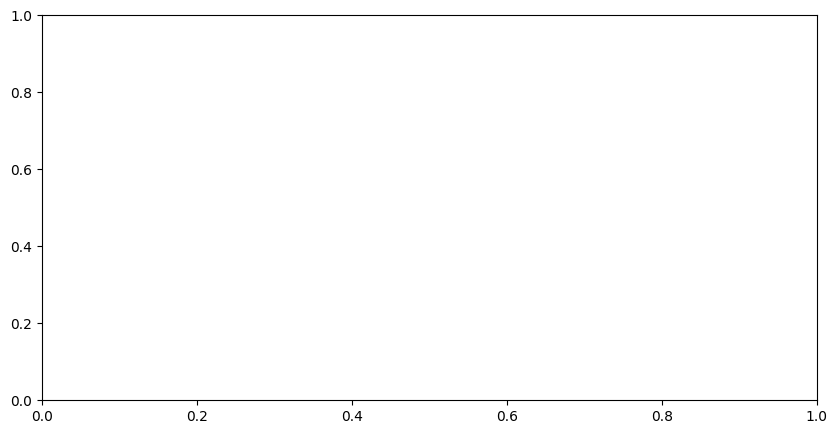

In [ ]:
# comprehensive training
best_metrics, history = train_model(
    model,
    train_loader,
    val_loader,
    device=device,
    num_epochs=20)

print(f"Best composite score: {best_metrics['composite_score']:.4f} at epoch {best_metrics['epoch']}")

#Test

In [ ]:
# testing the model on test dataset with metrics and visualization
def test_model(model, test_loader, device, num_images_to_visualize=0):
    # evaluation Metrics
    metrics = evaluate(model, test_loader, device)
    print_metrics(metrics, title="Test Metrics")

    # visualization
    model.eval()
    visualized = 0

    # creating a custom colormap for masks
    fracture_colors = ['black', 'red', 'green', 'blue', 'yellow', 'purple', 'cyan']
    cmap = ListedColormap(fracture_colors[:6])  # 5 classes + background

    with torch.no_grad():
        for images, targets in test_loader:
            if visualized >= num_images_to_visualize:
                break

            images = [img.to(device) for img in images]
            outputs = model(images)

            for i, (image, target, output) in enumerate(zip(images, targets, outputs)):
                if visualized >= num_images_to_visualize:
                    break

                # preparing data
                image = image.cpu().numpy().mean(axis=0)  # average across slices
                image = (image - image.min()) / (image.max() - image.min())

                # filtering predictions with score > 0.5
                keep = output['scores'] > 0.5
                pred_boxes = output['boxes'][keep].cpu().numpy()
                pred_labels = output['labels'][keep].cpu().numpy()
                pred_scores = output['scores'][keep].cpu().numpy()
                pred_masks = (output['masks'][keep] > 0.5).squeeze(1).cpu().numpy()


                # getting ground truth
                gt_boxes = target['boxes'].cpu().numpy()
                gt_labels = target['labels'].cpu().numpy()
                gt_masks = target['masks'].cpu().numpy()

                # creating figure
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

                # plotting ground truth
                ax1.imshow(image, cmap='gray')
                ax1.set_title('Ground Truth')

                # plotting ground truth boxes and masks
                for box, label, mask in zip(gt_boxes, gt_labels, gt_masks):
                    # Box
                    rect = patches.Rectangle(
                        (box[0], box[1]), box[2]-box[0], box[3]-box[1],
                        linewidth=1, edgecolor=fracture_colors[label], facecolor='none')
                    ax1.add_patch(rect)
                    ax1.text(box[0], box[1], f'GT {label}', color='white', fontsize=8,
                            bbox=dict(facecolor=fracture_colors[label], alpha=0.5))

                    # mask
                    mask = np.ma.masked_where(mask == 0, mask)
                    ax1.imshow(mask, cmap=cmap, alpha=0.3, vmin=0, vmax=5)

                # plotting predictions
                ax2.imshow(image, cmap='gray')
                ax2.set_title('Predictions')

                for box, label, score, mask in zip(pred_boxes, pred_labels, pred_scores, pred_masks):
                    # box
                    rect = patches.Rectangle(
                        (box[0], box[1]), box[2]-box[0], box[3]-box[1],
                        linewidth=1, edgecolor=fracture_colors[label], facecolor='none')
                    ax2.add_patch(rect)
                    ax2.text(box[0], box[1], f'P {label} ({score:.2f})', color='white', fontsize=8,
                            bbox=dict(facecolor=fracture_colors[label], alpha=0.5))

                    # Maskmask
                    mask = np.ma.masked_where(mask == 0, mask)
                    ax2.imshow(mask, cmap=cmap, alpha=0.3, vmin=0, vmax=5)

                plt.suptitle(f'CT Slice - Fracture Detection (Image {visualized+1})')
                plt.tight_layout()
                plt.show()

                visualized += 1

In [ ]:
def run_test_pipeline(model_path, test_loader, device):

    checkpoint = torch.load(model_path, map_location=device, weights_only=False)

    #loading back model to test
    model = create_ribfrac_model(num_classes=6, device=device,trainable_backbone_layers=3), model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)

    test_model(model, test_loader, device, num_images_to_visualize=300)

Frozen layers:
- backbone.body.layer1.0.conv1.weight
- backbone.body.layer1.0.conv2.weight
- backbone.body.layer1.0.conv3.weight
- backbone.body.layer1.0.downsample.0.weight
- backbone.body.layer1.1.conv1.weight
- backbone.body.layer1.1.conv2.weight
- backbone.body.layer1.1.conv3.weight
- backbone.body.layer1.2.conv1.weight
- backbone.body.layer1.2.conv2.weight
- backbone.body.layer1.2.conv3.weight

Total params: 45,504,511 | Trainable: 45,291,519 (99.5%)


<ipython-input-14-e25452d9b5e3>:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  froc_auc = np.trapz(sensitivity[valid_mask], fp_per_image[valid_mask])



----------------------------------------
              TEST METRICS              
----------------------------------------

[OBJECT DETECTION METRICS]
• mAP@0.3:       0.0484 (All classes)
• mAP@0.5:       0.0448 (All classes)
• FP Rate:       2.50 FP/image
• Total Detects: 21784 (All images)

[CLASS-WISE DETECTION]
Class   mAP@0.3     mAP@0.5     Recall      Precision   
1       0.0000      0.0000      0.7909      0.5362      
2       0.1862      0.1811      0.3455      0.3154      
3       0.0543      0.0479      0.1500      0.1329      
4       0.0028      0.0020      0.0747      0.0917      
5       0.0264      0.0245      0.6455      0.3989      

[SEGMENTATION QUALITY]
• Overall Dice:  0.4271
• FROC AUC:      0.6460
• Sens@1FP/img:  0.3574

[CLASS-WISE DICE SCORES]
Class   Dice        Type                
1       0.6093      Displaced           
2       0.4874      Non-displaced       
3       0.3227      Buckle              
4       0.4074      Segmental           
5       0.30

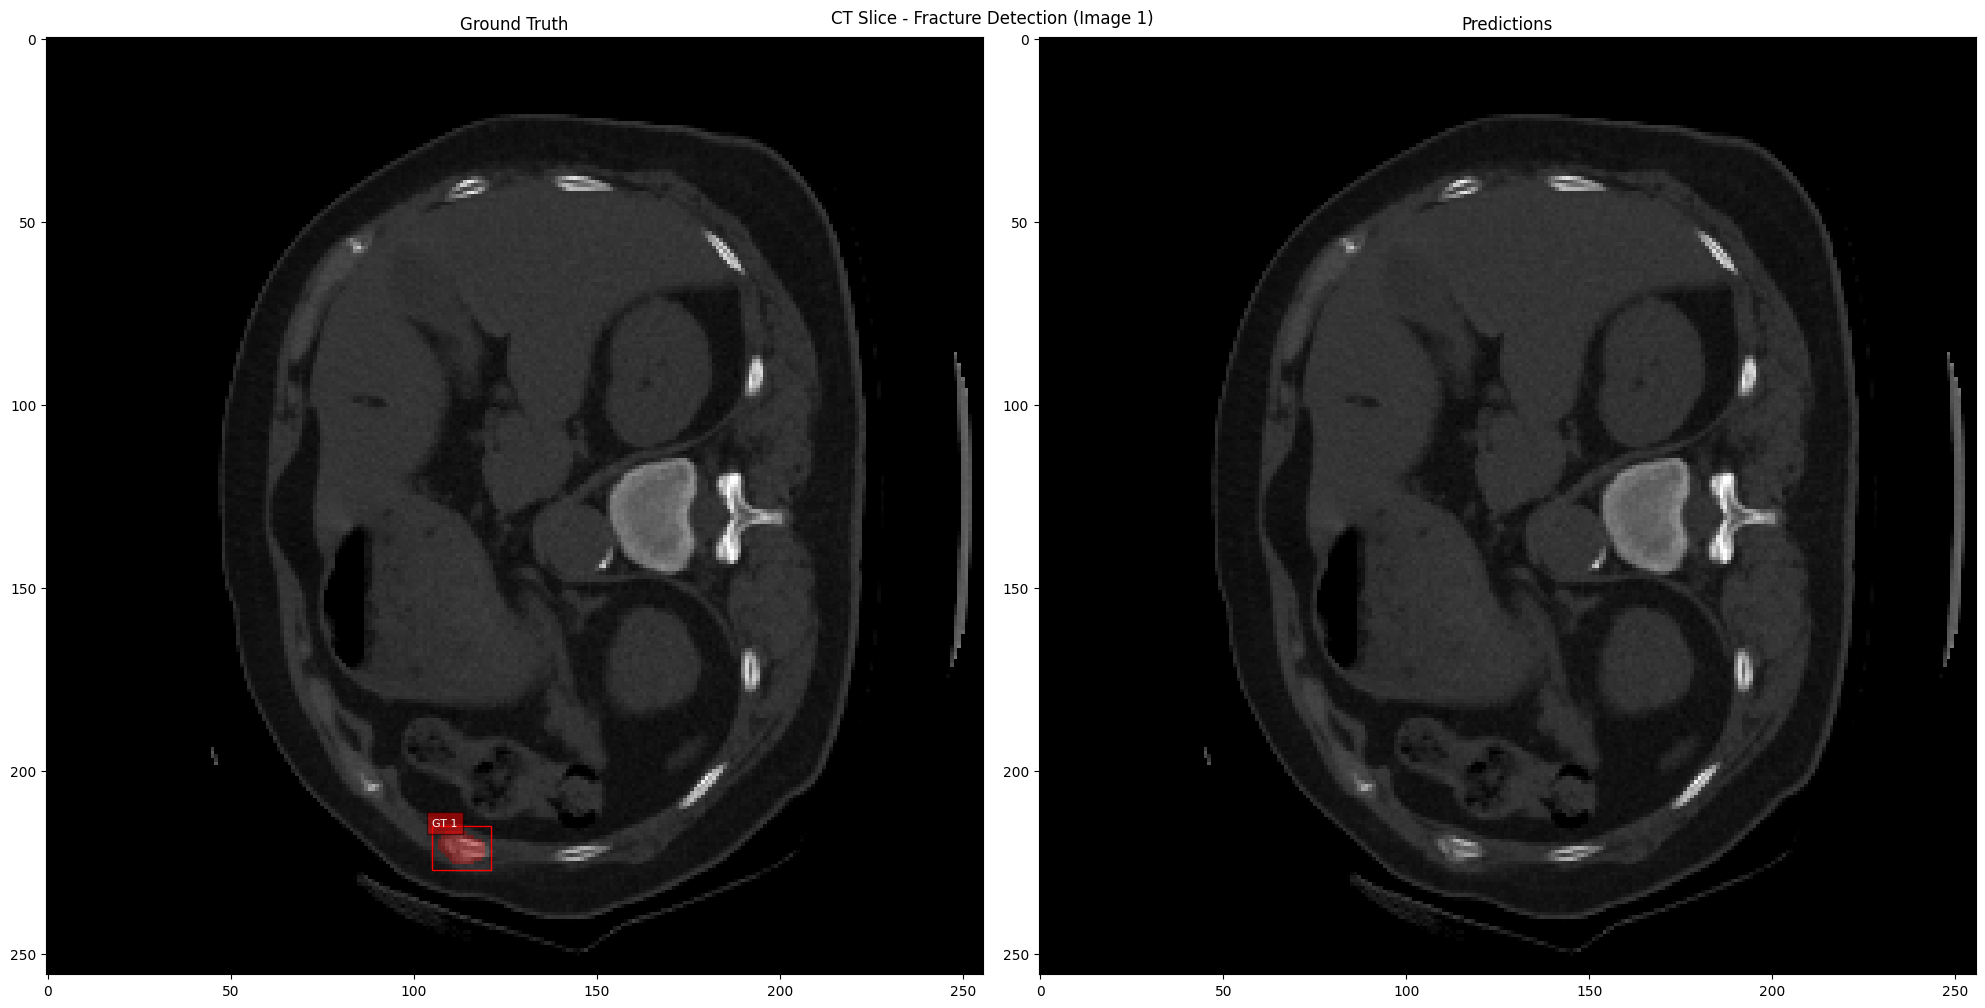

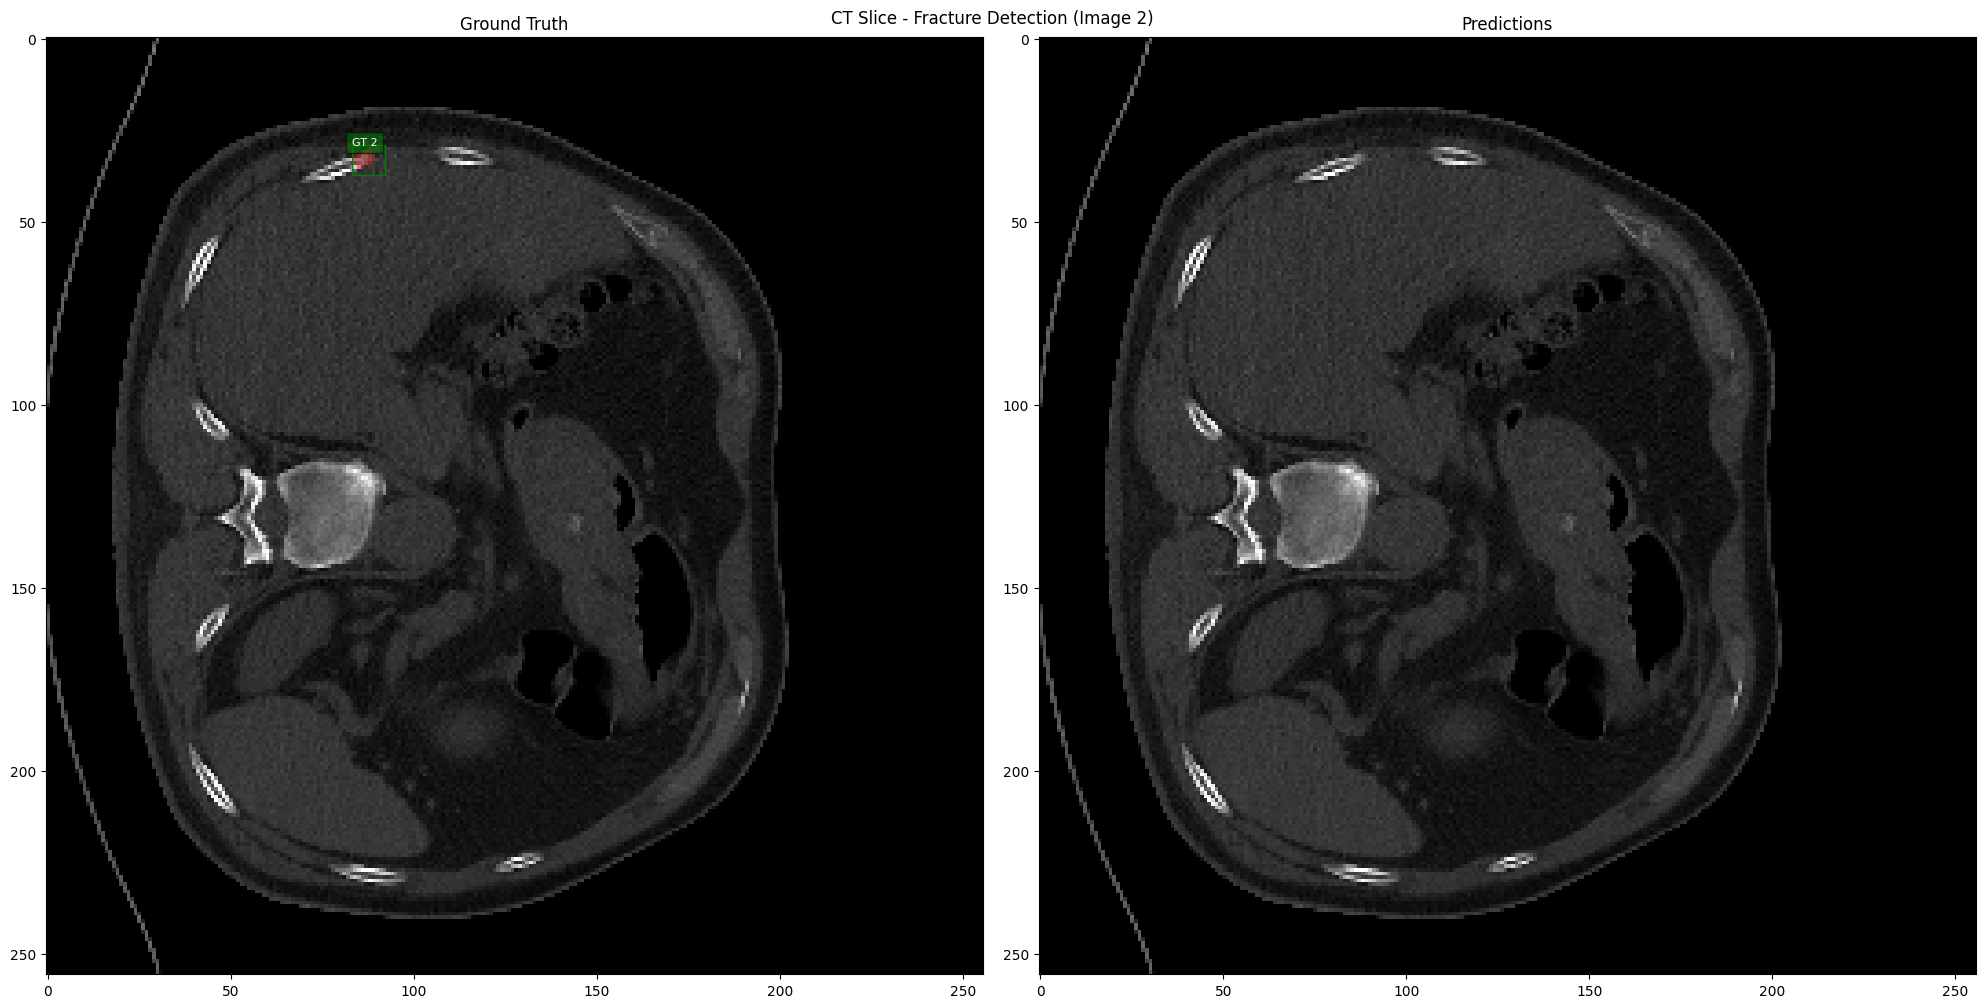

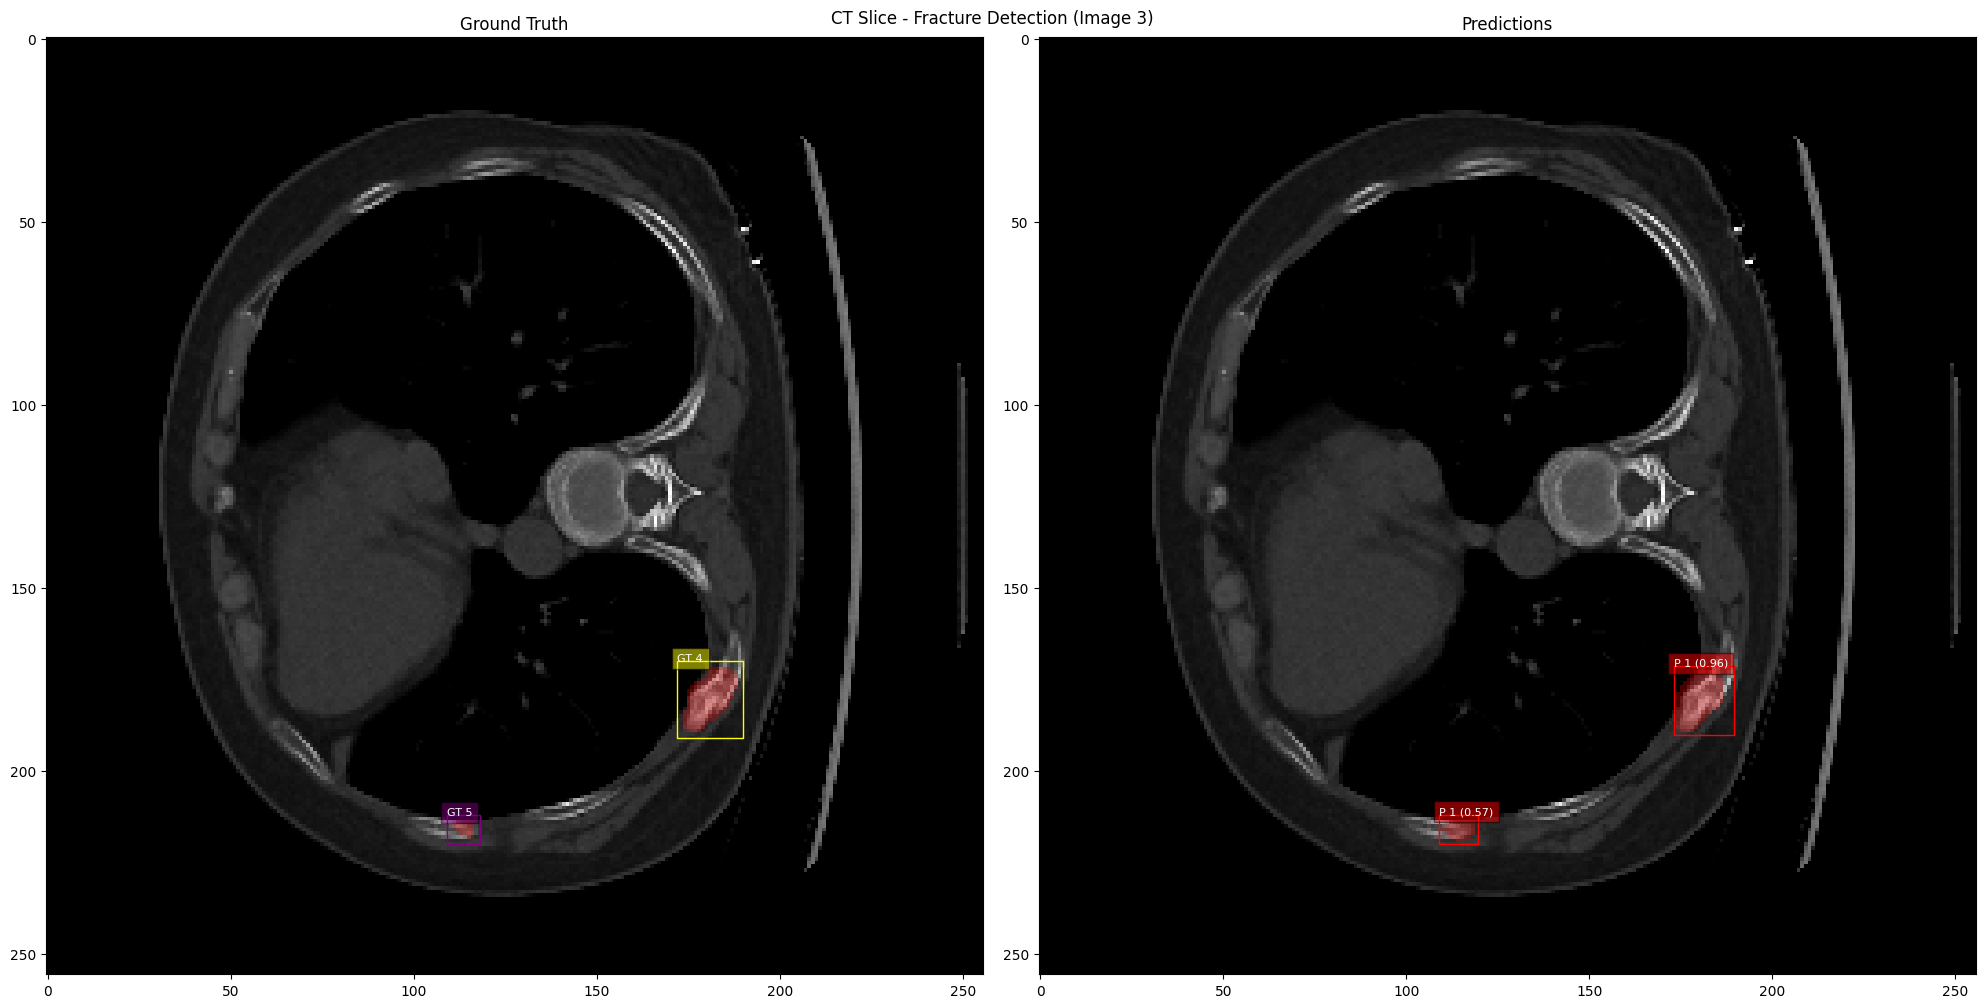

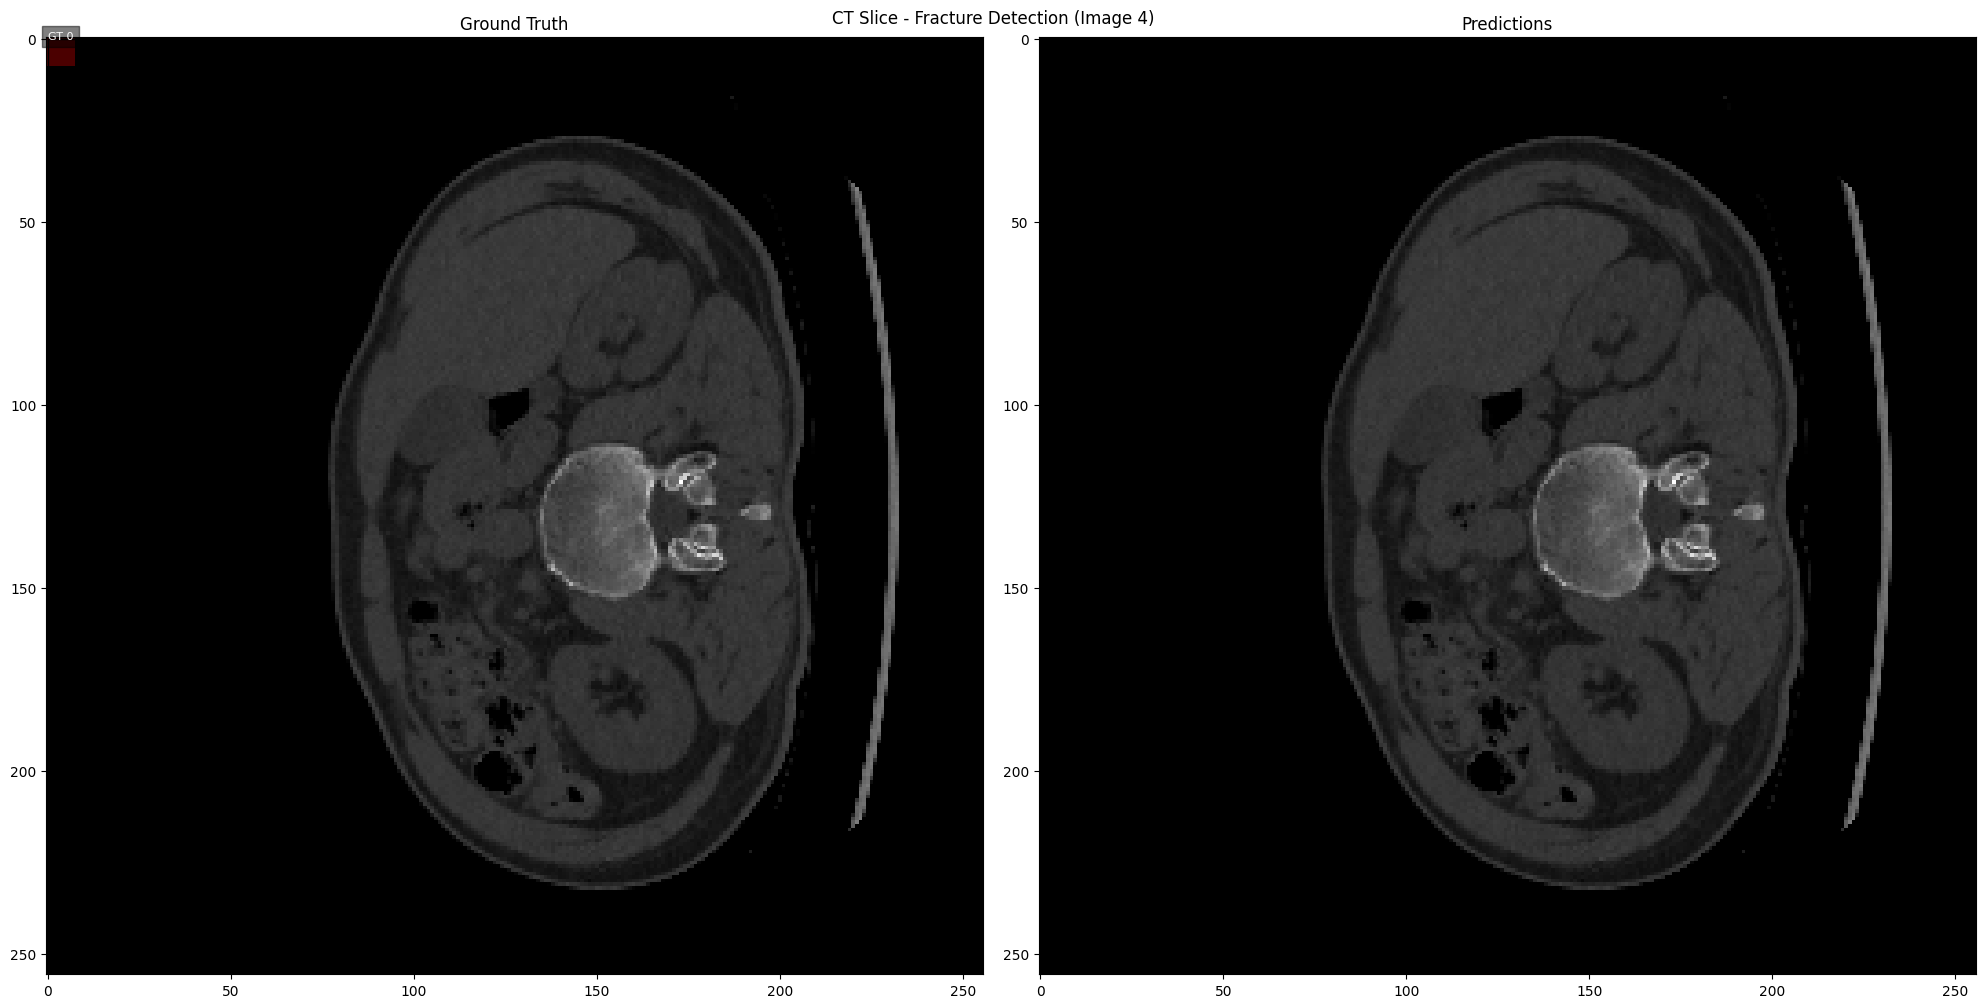

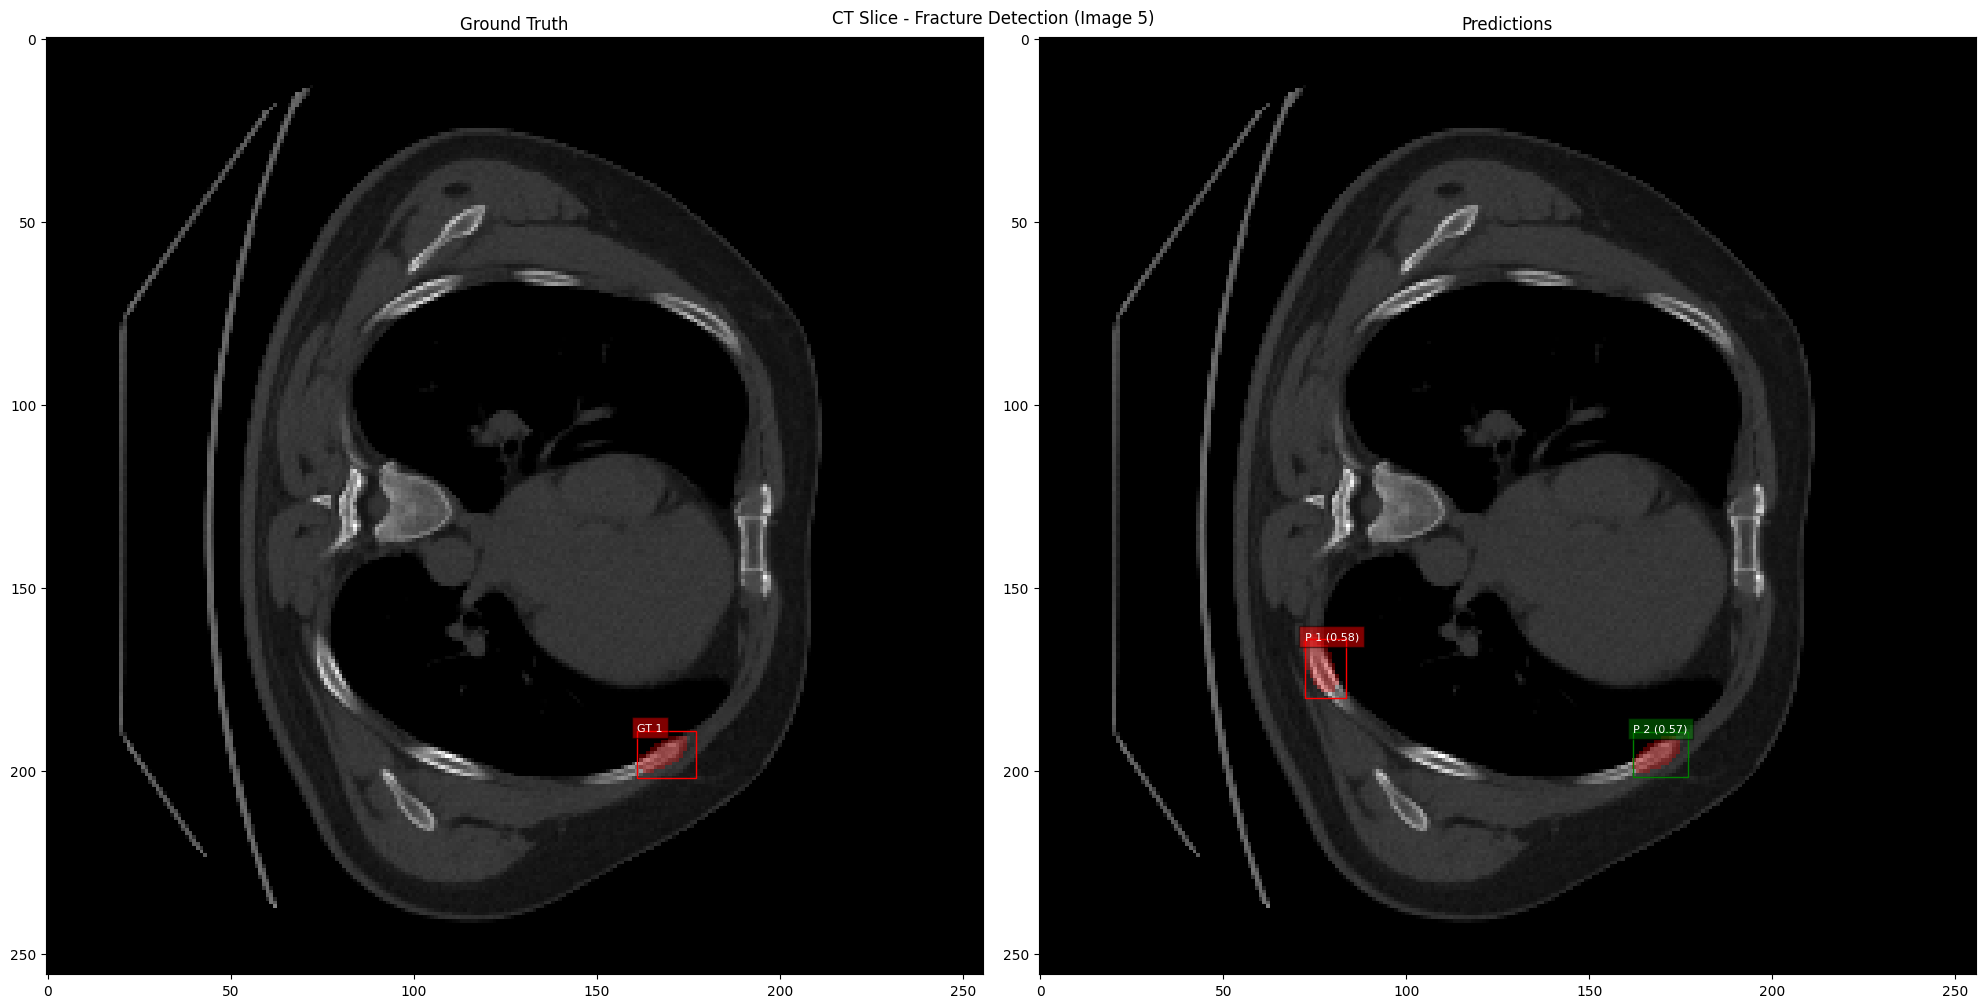

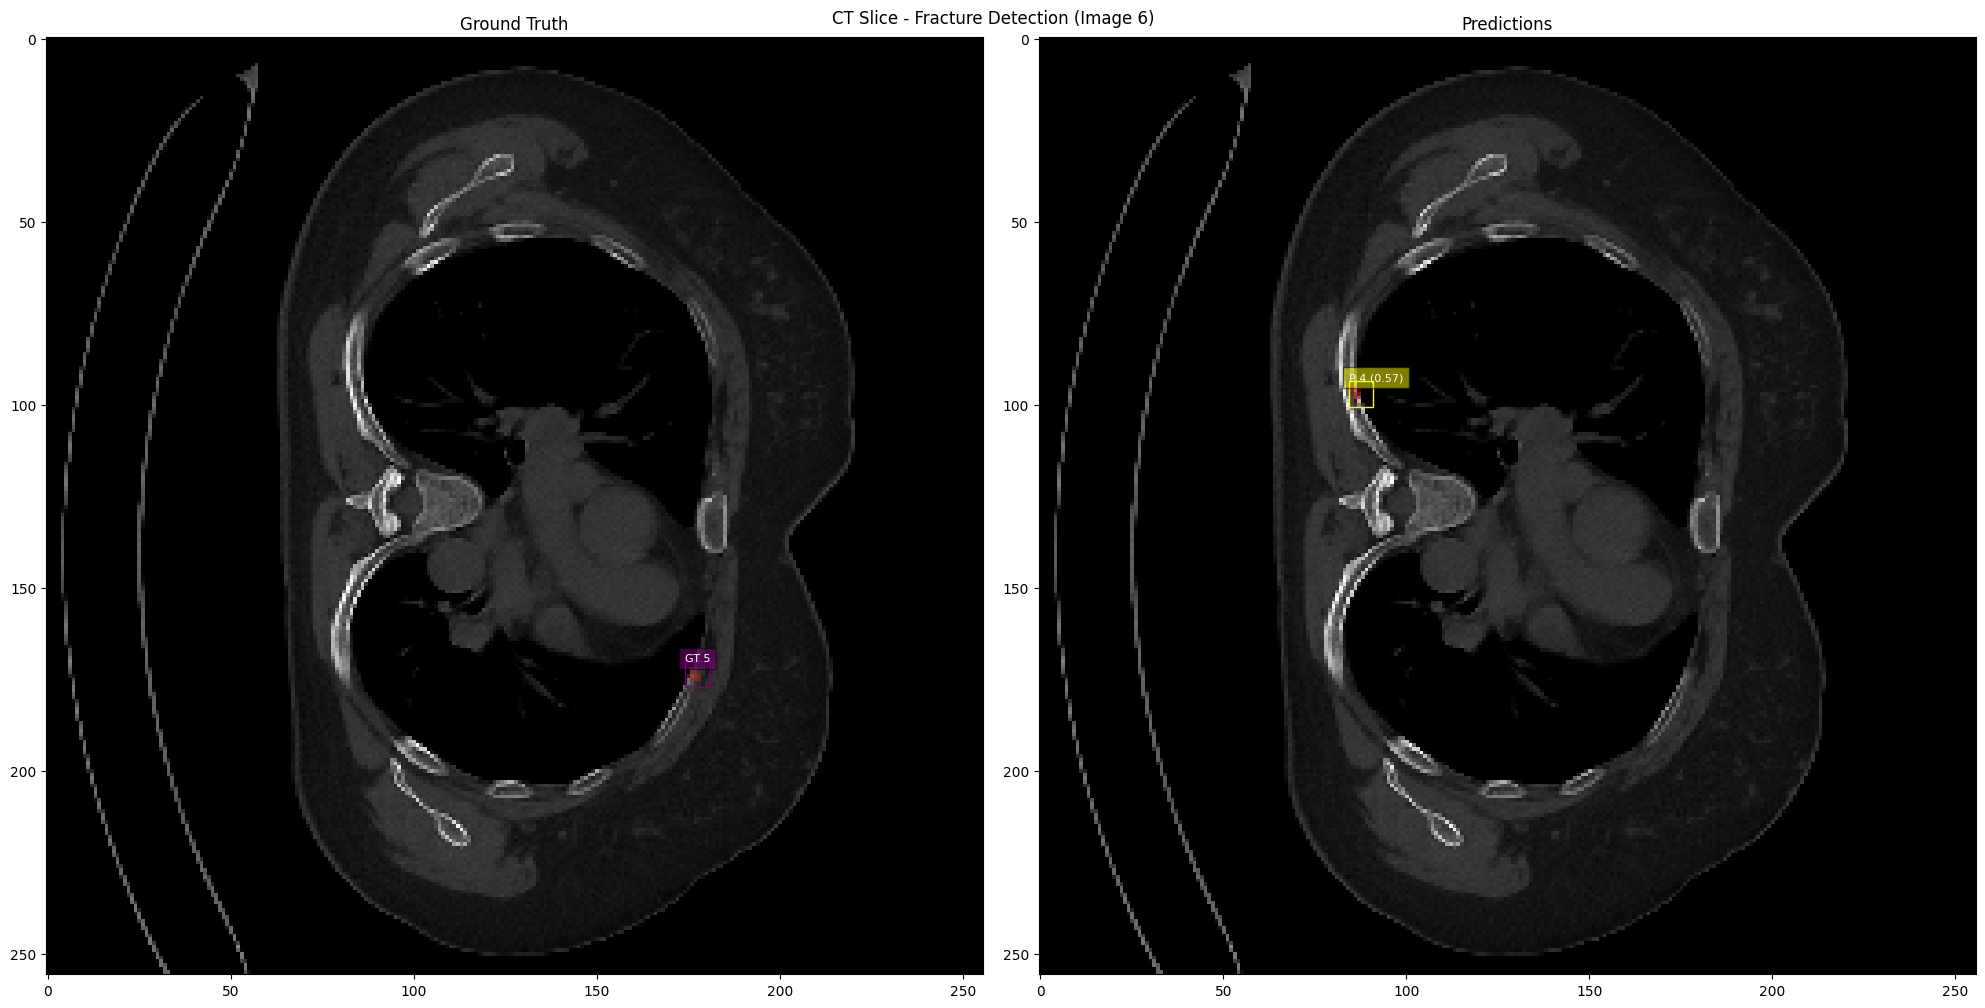

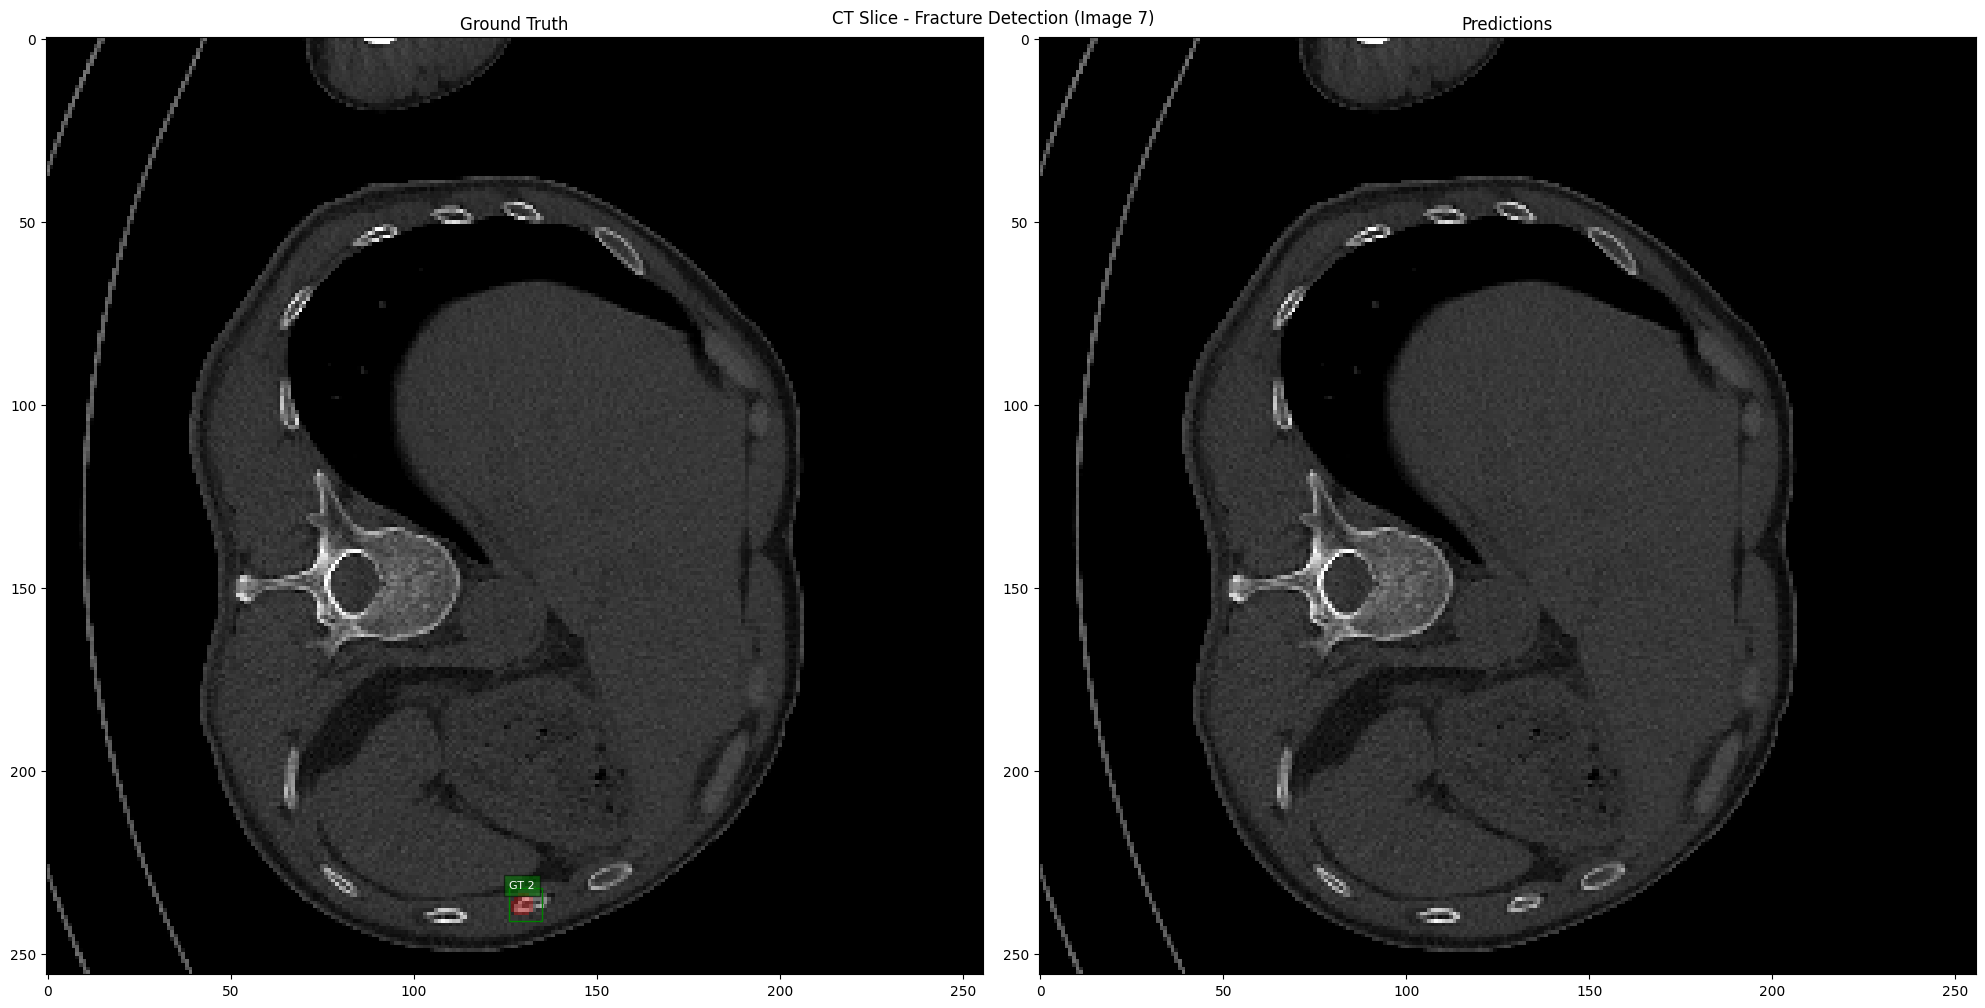

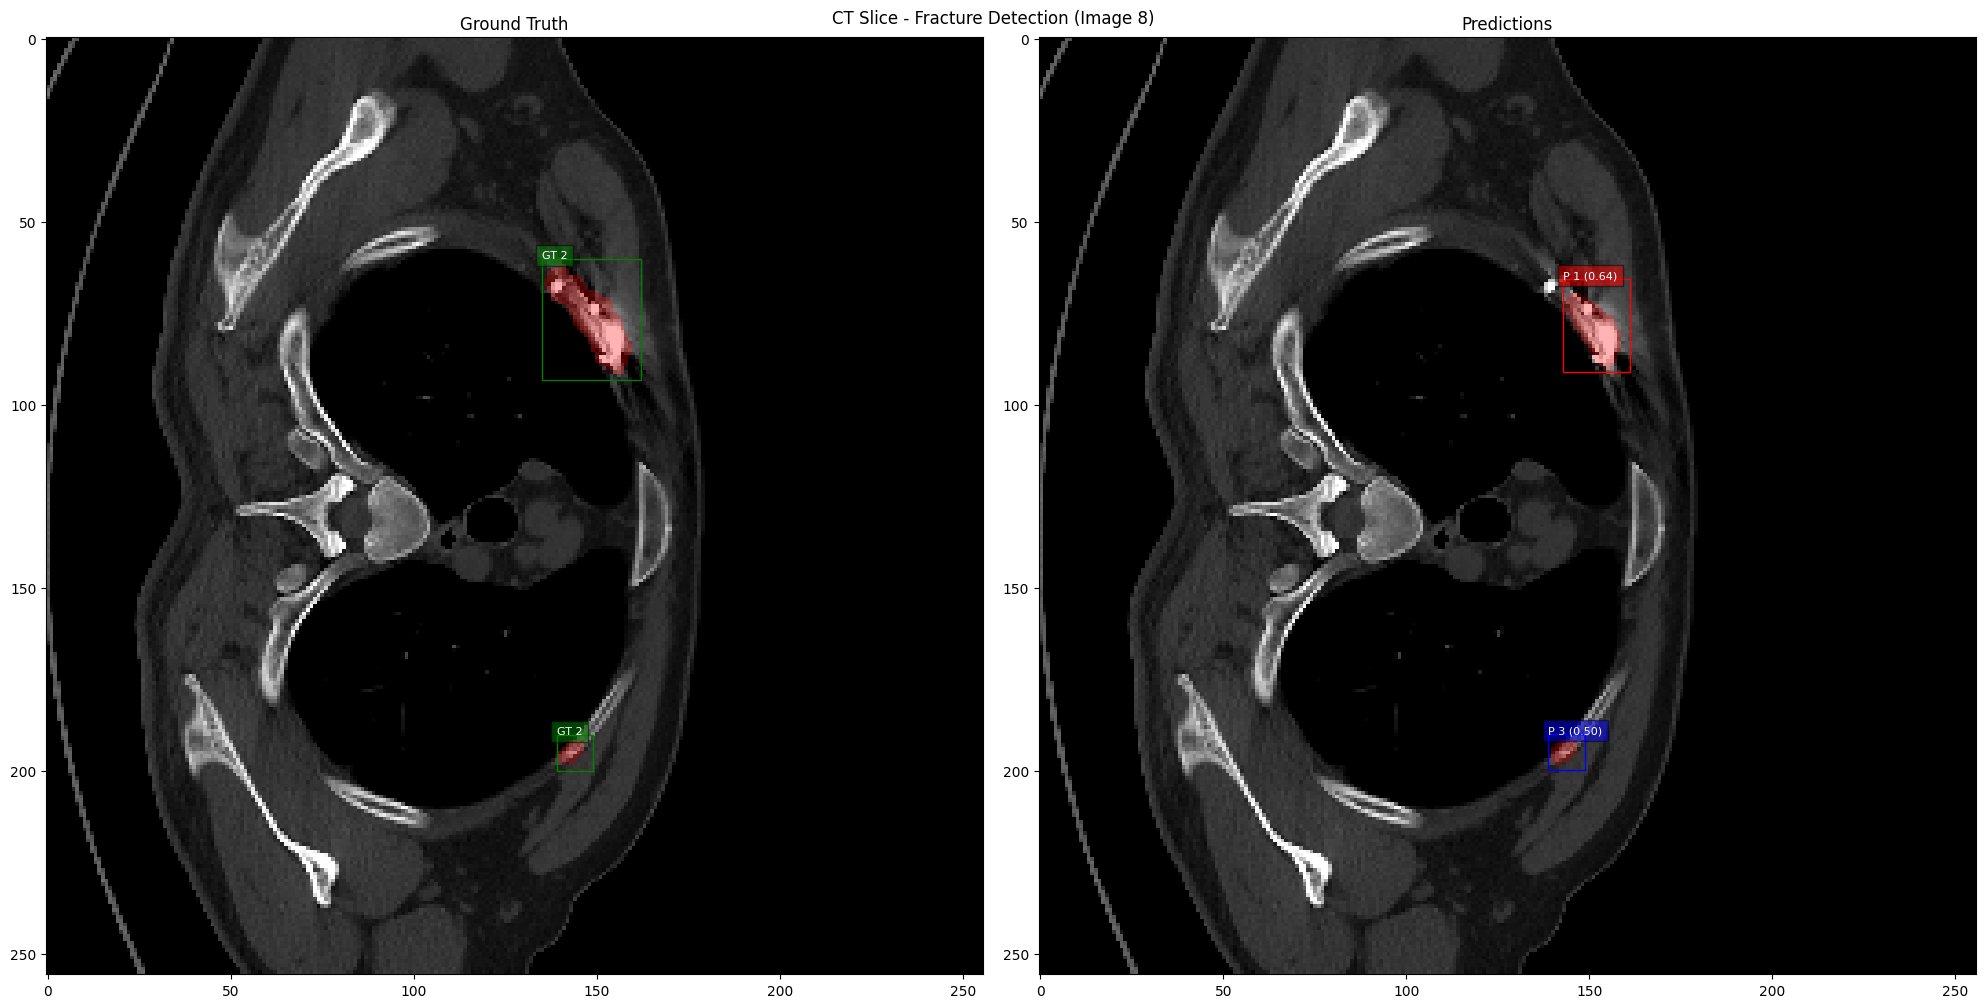

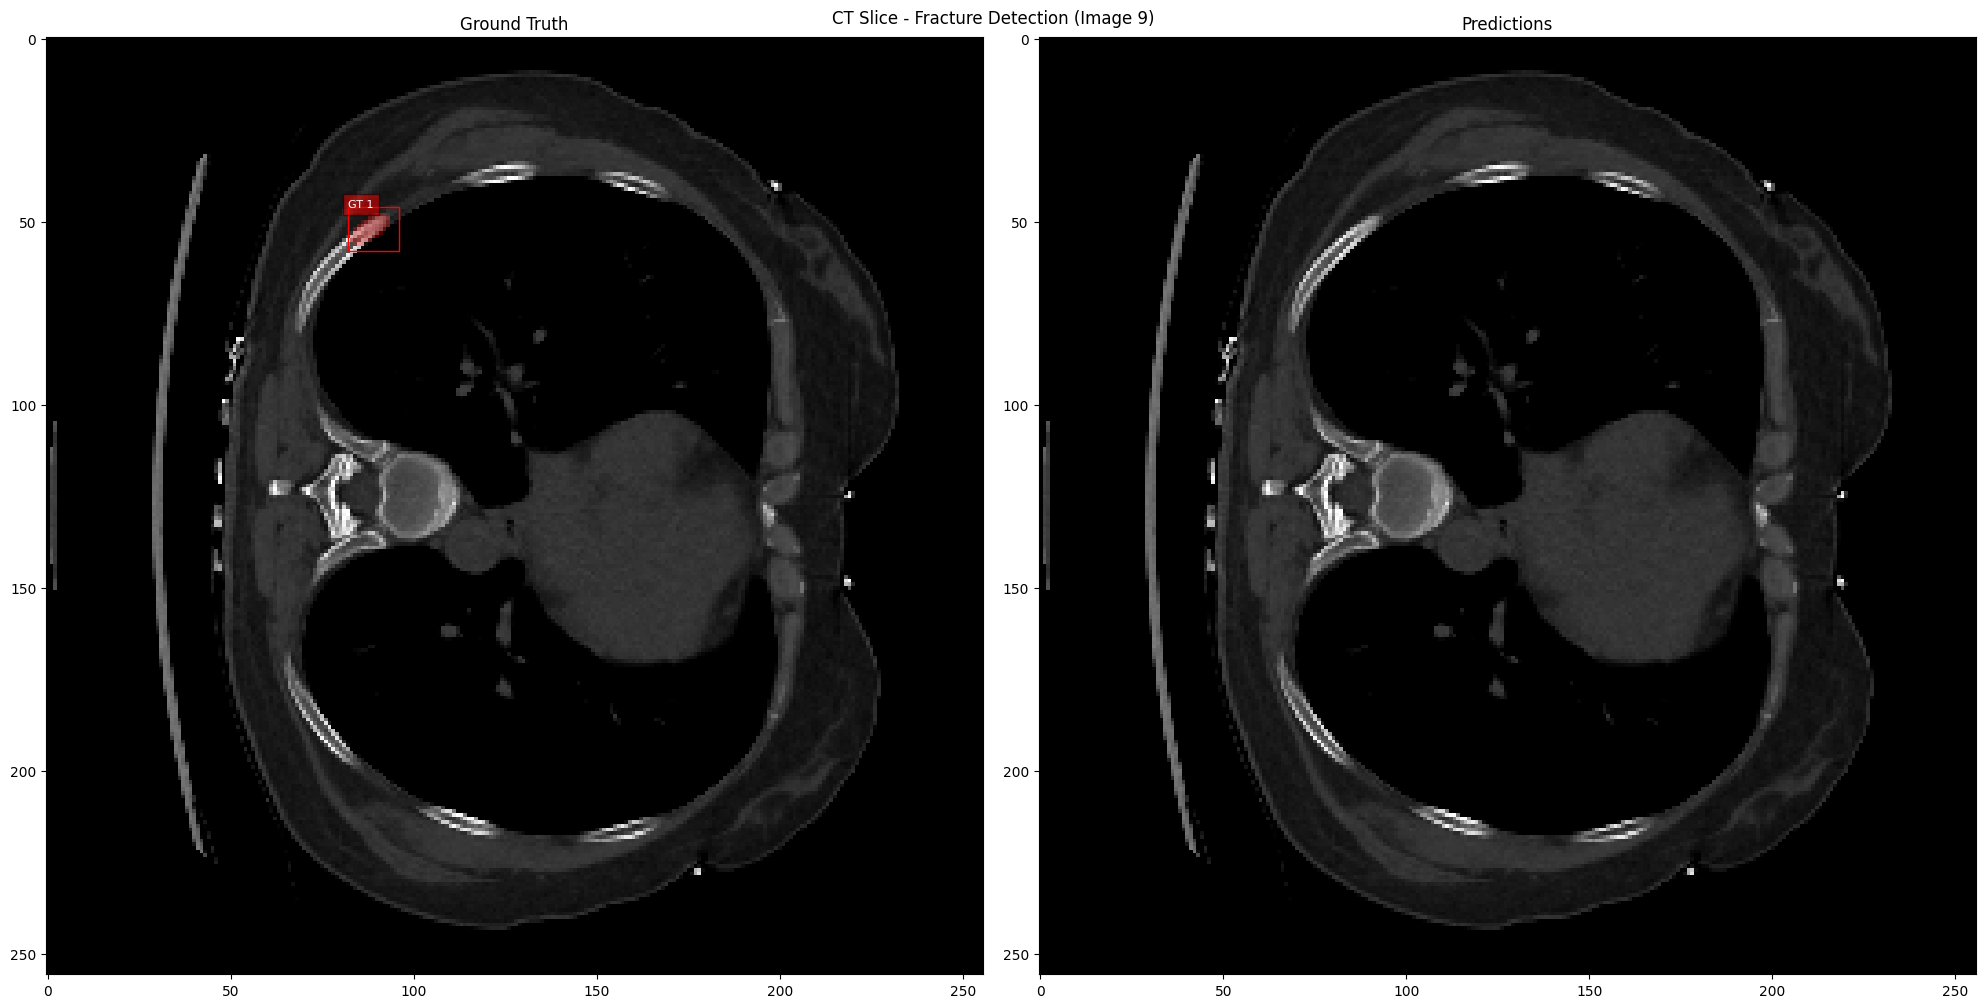

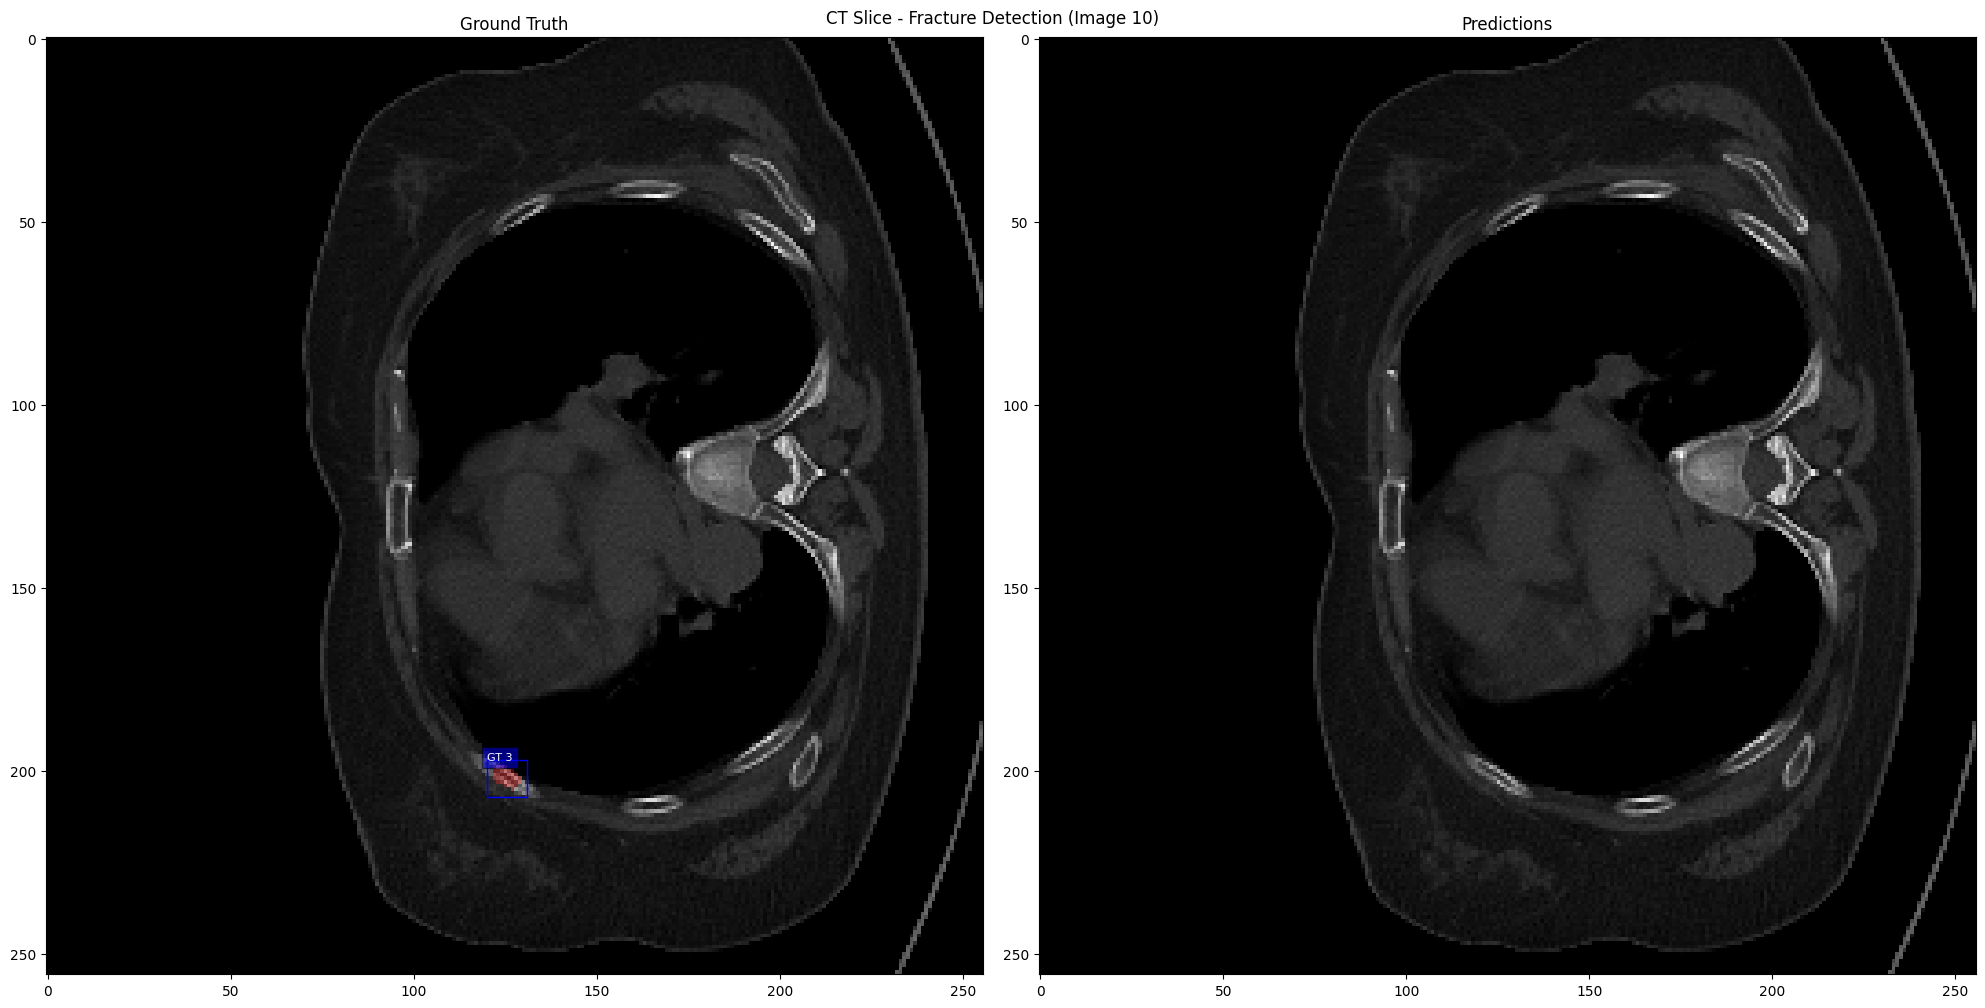

In [ ]:
run_test_pipeline("/content/drive/MyDrive/checkpoints/best_model.pth", test_loader, device)